# Análisis Predictivo de Series Temporales



## Redes Neuronales aplicadas a Series Temporales


## Objetivo

El objetivo de este cuaderno es introducir algunos ejemplos de ajuste de redes neuronales en el contexto de análsiis de series temporales. En particular:

 * Discutir cómo convertir el problema de ajuste de modelos a un problema de aprendizaje supervisado.
 
 * Analizar la relación entre RNN clásicas y los modelos lineales ya vistos.
 
 * Discutir algunos ejemplos más complejos de redes (CNN, RNN, LSTM).
 
 * Observar cómo se puede realizar la predicción.
 
 
Nos basaremos en algunas bibliotecas de `R` que interactúan con `tensorflow`, por lo que es necesario una instalación de Python con tensorflow para que funcione. En particular usaremos la biblioteca `keras`.

In [72]:
# read in the packages we'll use
library(keras) # for deep learning
library(astsa)
options(repr.plot.width=15, repr.plot.height=8) #ajusta tamaño de graficas

### Ejemplo

Trabajaremos en un principio con la serie de mortalidad que ya vimos:

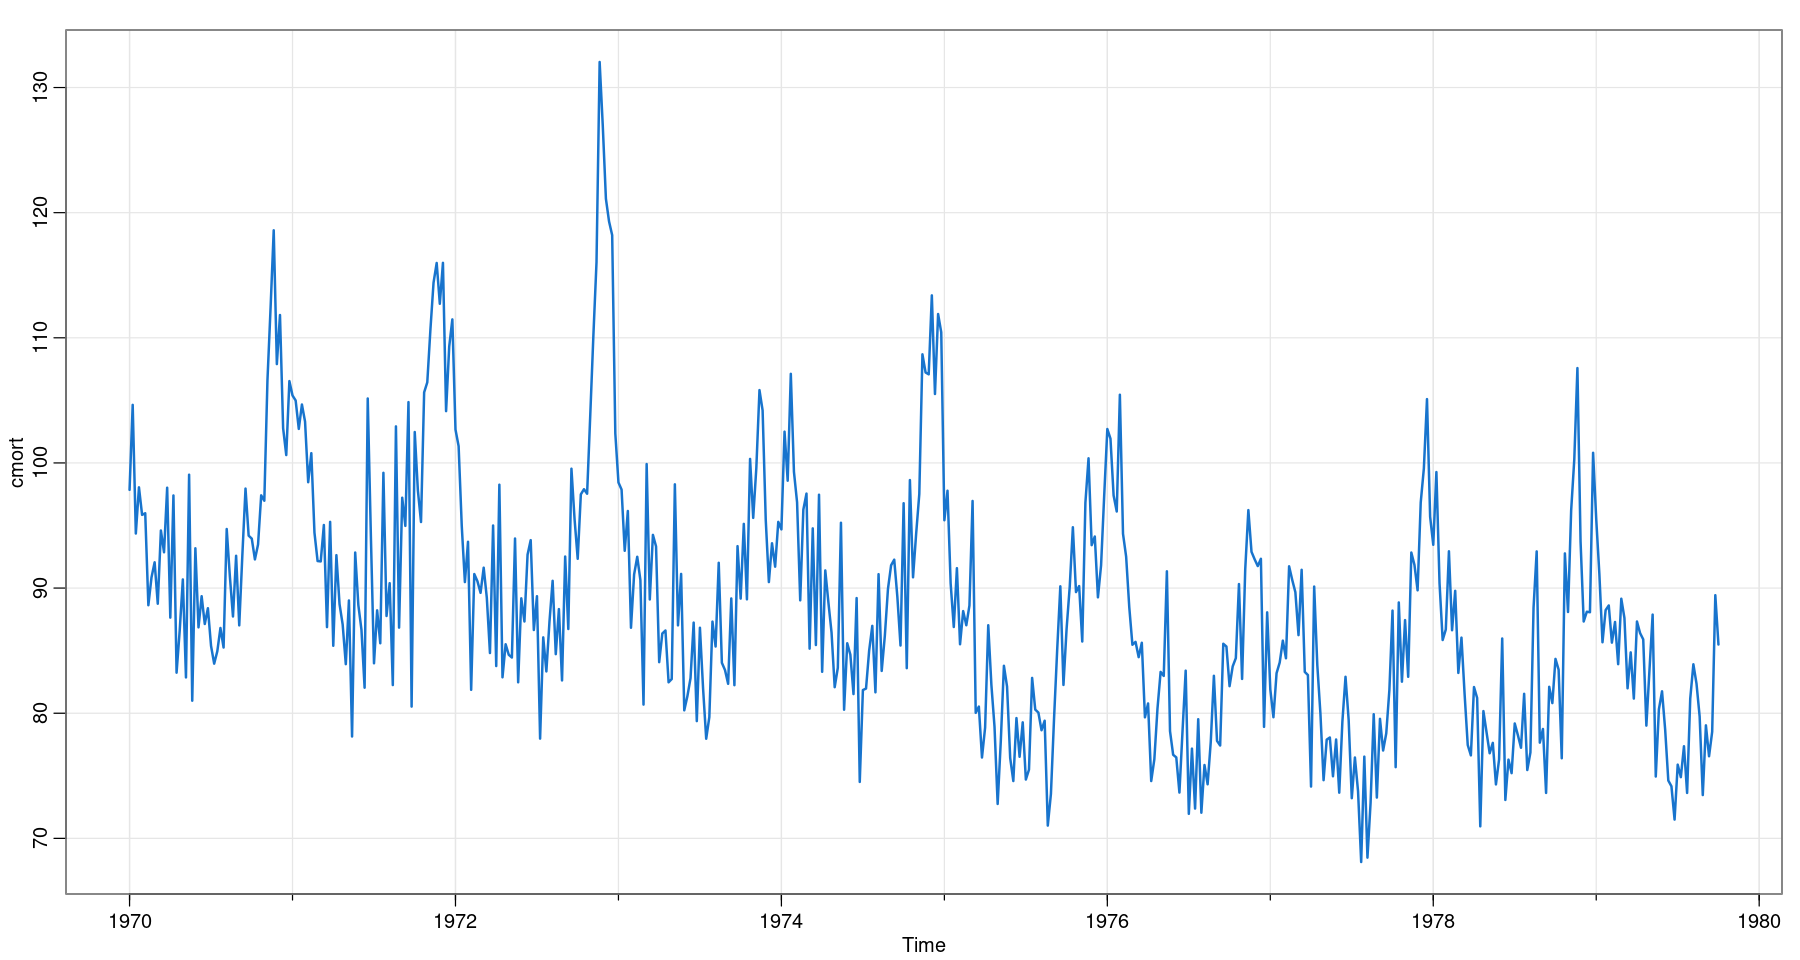

In [73]:
tsplot(cmort, lwd=2, col=4)

### Estacionarización

Como vimos antes, resulta útil llevar primero la serie a algo estacionario. En este caso, le quitamos la tendencia.

In [74]:
fit = lm(cmort~time(cmort))
summary(fit)


Call:
lm(formula = cmort ~ time(cmort))

Residuals:
    Min      1Q  Median      3Q     Max 
-16.445  -6.670  -1.366   5.505  40.107 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3297.6062   276.3132   11.93   <2e-16 ***
time(cmort)   -1.6249     0.1399  -11.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.893 on 506 degrees of freedom
Multiple R-squared:  0.2104,	Adjusted R-squared:  0.2089 
F-statistic: 134.9 on 1 and 506 DF,  p-value: < 2.2e-16


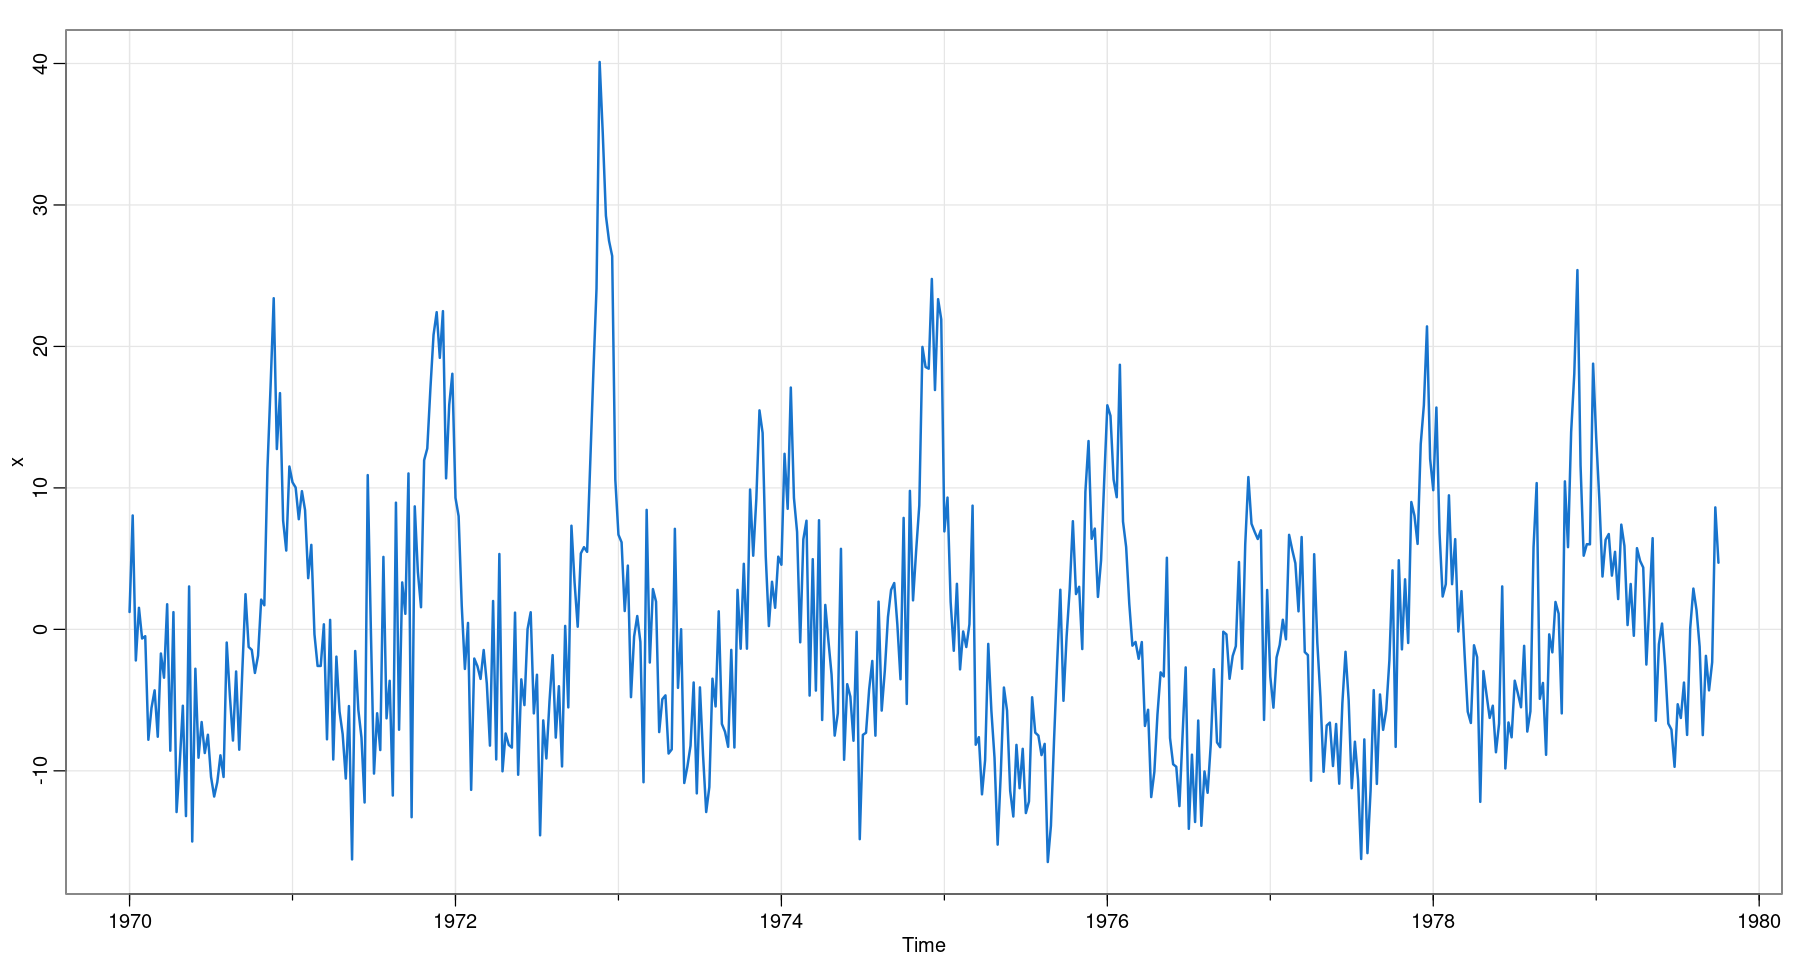

In [75]:
x=residuals(fit)
x=ts(x, start=1970, freq=52)
tsplot(x, lwd=2, col=4)

## Aprendizaje en series temporales

Las redes neuronales sirven para realizar aprendizaje *supervisado*, esto es, a partir de ejemplos, encontrar los coeficientes de la red que minimizan una función de *loss* o pérdida. En este caso:

* Los ejemplos son "ventanas" de valores en el tiempo de la serie, y uno o más features que nos interese incorporar:

     * Por ejemplo, el valor de la semana del año en este caso importa debido a la variación anual.
     * Pueden ser también diferentes "features" como la temperatura y partículas que ya vimos.
     
* El valor a predecir es por ejemplo, el siguiente valor de la serie, o una ventana hacia adelante.

* En base a esto, se arma una arquitectura de red y se entrena usando backpropagation.

### Diagrama

Para el caso por ejemplo de tomar 6 lags:

![split window](split_window.png)

### Preprocesamiento

En este caso, haremos varios modelos. El primero simplemente usa como feature la propia serie, usando una cantidad `window` de lags. Separamos ademas una parte para testear predicciones.

In [94]:
window=3
pred = 1
x_train = x[time(x)<1978]

n=length(x_train)
print(n)

X_train = matrix(,n-window-pred+1,window)
y_train = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_train[i,] = x_train[i:(i+window-1)]
    y_train[i,] = x_train[(i+window):(i+window+pred-1)]
}
dim(X_train)
dim(y_train)

head(X_train)
head(y_train)
head(x_train)

[1] 416


[1] 413   3

[1] 413   1

[,1]       [,2]       [,3]      
[1,]  1.2299000  8.0511474 -2.1976052
[2,]  8.0511474 -2.1976052  1.5236423
[3,] -2.1976052  1.5236423 -0.6451103
[4,]  1.5236423 -0.6451103 -0.4838629
[5,] -0.6451103 -0.4838629 -7.8026155
[6,] -0.4838629 -7.8026155 -5.5513680

[,1]      
[1,]  1.5236423
[2,] -0.6451103
[3,] -0.4838629
[4,] -7.8026155
[5,] -5.5513680
[6,] -4.3101206

1          2          3          4          5          6 
 1.2299000  8.0511474 -2.1976052  1.5236423 -0.6451103 -0.4838629

In [95]:
# Armo el "tensor" de entrenamiento
X_train = array(X_train, dim = c(n-window-pred+1, window, 1))

#dimensiones: no. muestras, tiempos involucrados, no. features
dim(X_train)

[1] 413   3   1

## Modelo 1: una única capa densa.

Esto coincide con el modelo lineal del autorregresivo que ya vimos.

In [106]:
# initialize our model
model1 <- keras_model_sequential()

model1 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 1)

In [107]:
summary(model1)

Model: "sequential_12"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_8 (Flatten)                 (None, 3)                       0           
________________________________________________________________________________
dense_18 (Dense)                    (None, 1)                       4           
Total params: 4
Trainable params: 4
Non-trainable params: 0
________________________________________________________________________________


In [108]:
model1 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [109]:
trained_model <- model1 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 300, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



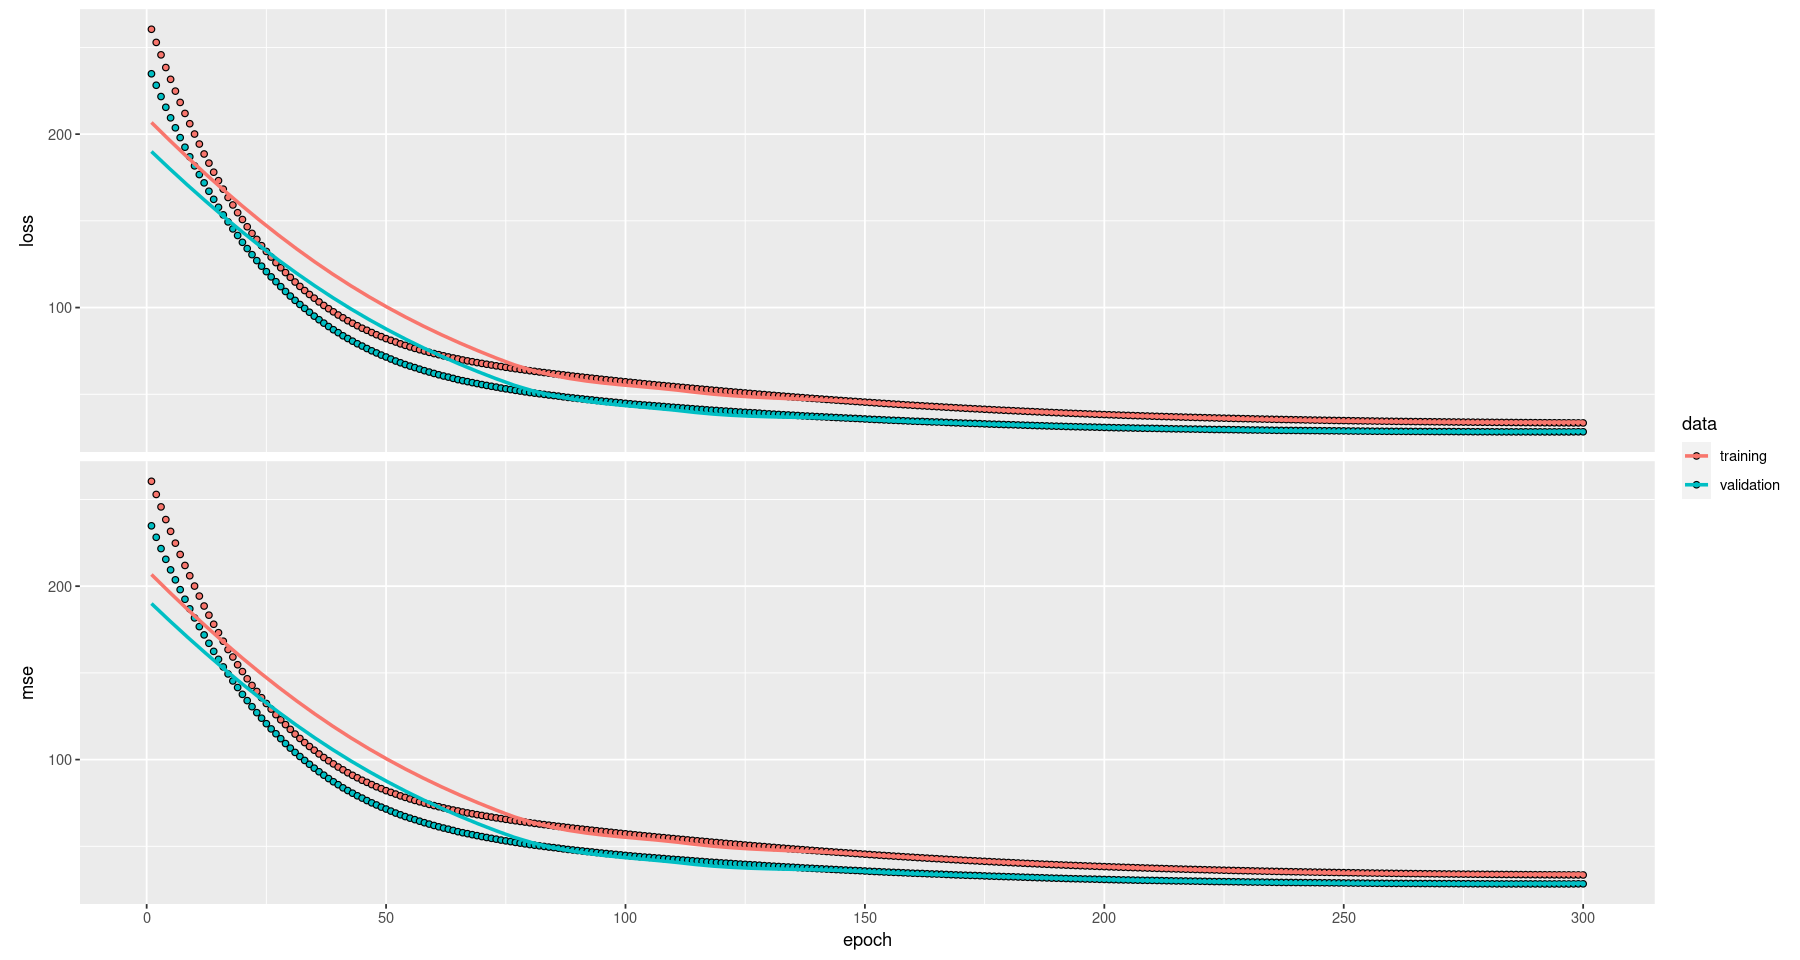

In [110]:
plot(trained_model)

In [112]:
evaluate(model1,X_train,y_train)

loss      mse 
32.94717 32.94717

In [113]:
model1$weights

[[1]]
<tf.Variable 'dense_18/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[0.0703532 ],
       [0.48494577],
       [0.27746394]], dtype=float32)>

[[2]]
<tf.Variable 'dense_18/bias:0' shape=(1,) dtype=float32, numpy=array([0.00459958], dtype=float32)>


In [118]:
arima(x_train,order = c(3,0,0), method="CSS")


Call:
arima(x = x_train, order = c(3, 0, 0), method = "CSS")

Coefficients:
         ar1     ar2      ar3  intercept
      0.3918  0.4613  -0.0003     0.0569
s.e.  0.0490  0.0476   0.0492     1.9005

sigma^2 estimated as 32.5:  part log likelihood = -1314.39

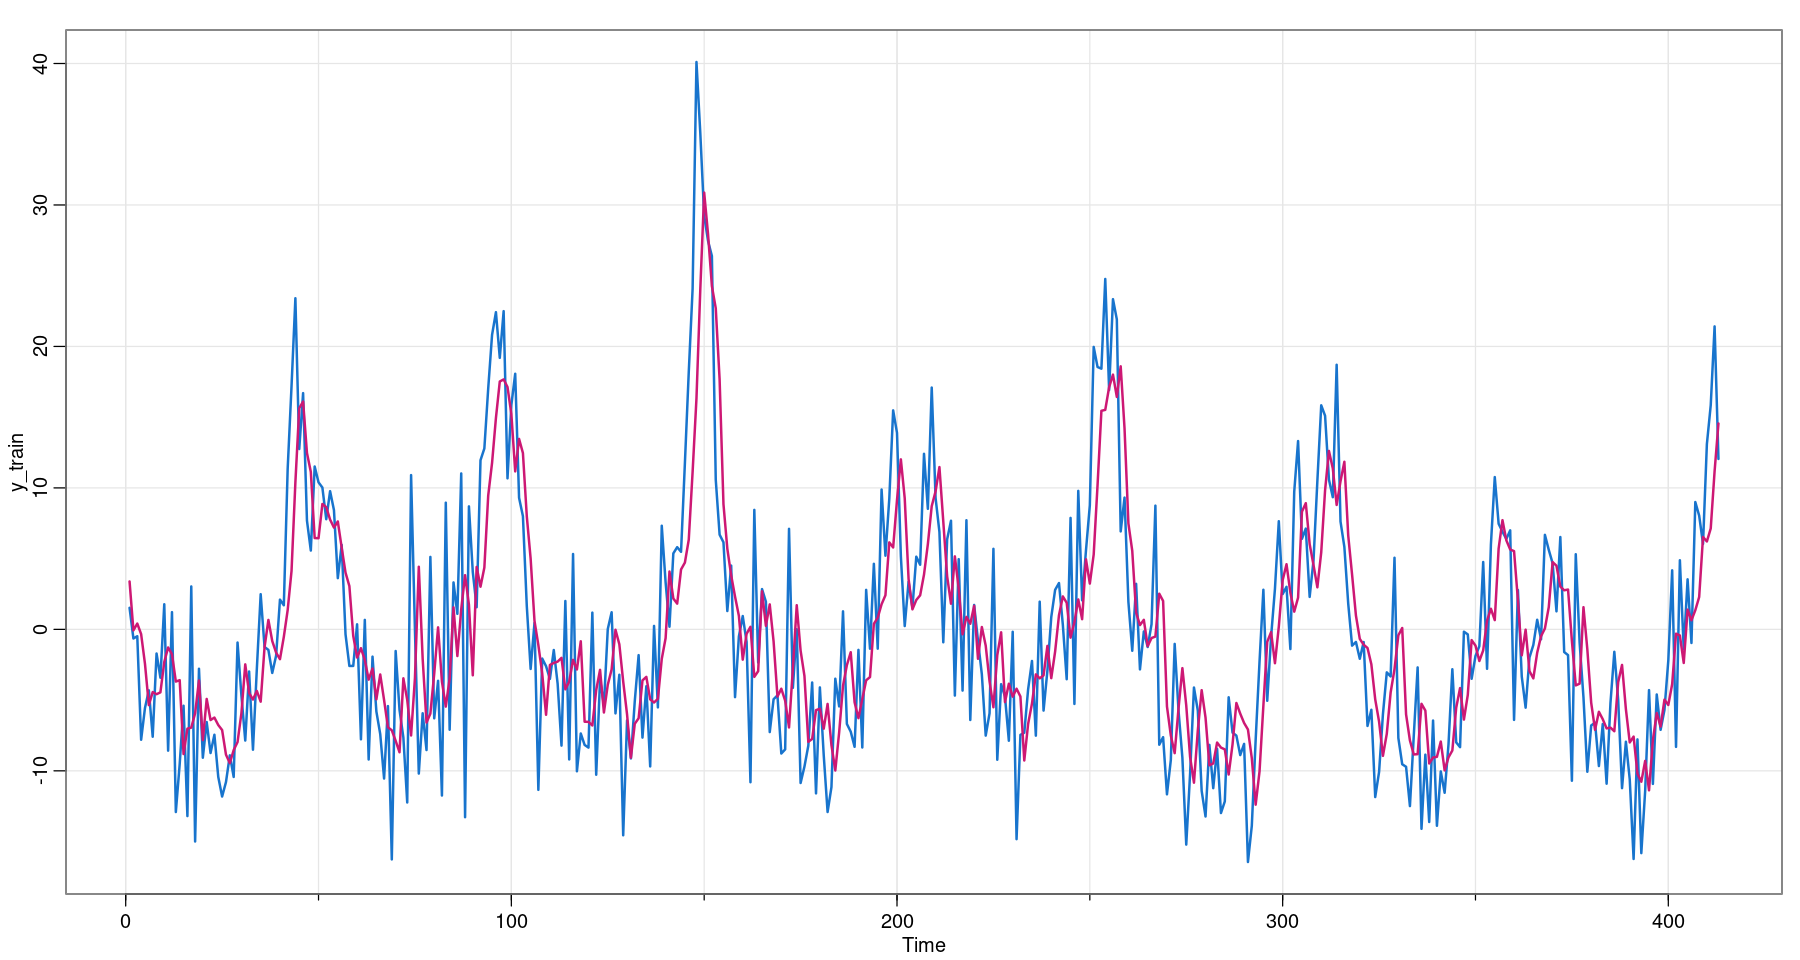

In [127]:
y1 = predict(model1,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y1, col=6, lwd=2)

## Modelo 2: múltiples capas densas

Agreguemos algunas capas para darle no linealidad al modelo. Usamos como función de activación `relu`, es decir $a(x)=\max\{x,0\}$.

In [163]:
# initialize our model
model2 <- keras_model_sequential()

model2 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units=32, activation='relu') %>%
    layer_dense(units = 1)

In [164]:
summary(model2)

Model: "sequential_16"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_12 (Flatten)                (None, 3)                       0           
________________________________________________________________________________
dense_27 (Dense)                    (None, 32)                      128         
________________________________________________________________________________
dense_26 (Dense)                    (None, 1)                       33          
Total params: 161
Trainable params: 161
Non-trainable params: 0
________________________________________________________________________________


In [165]:
model2 %>% compile(loss = 'mse', 
                  optimizer = 'adam',
                  metrics = c('mse'))

In [166]:
trained_model2 <- model2 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



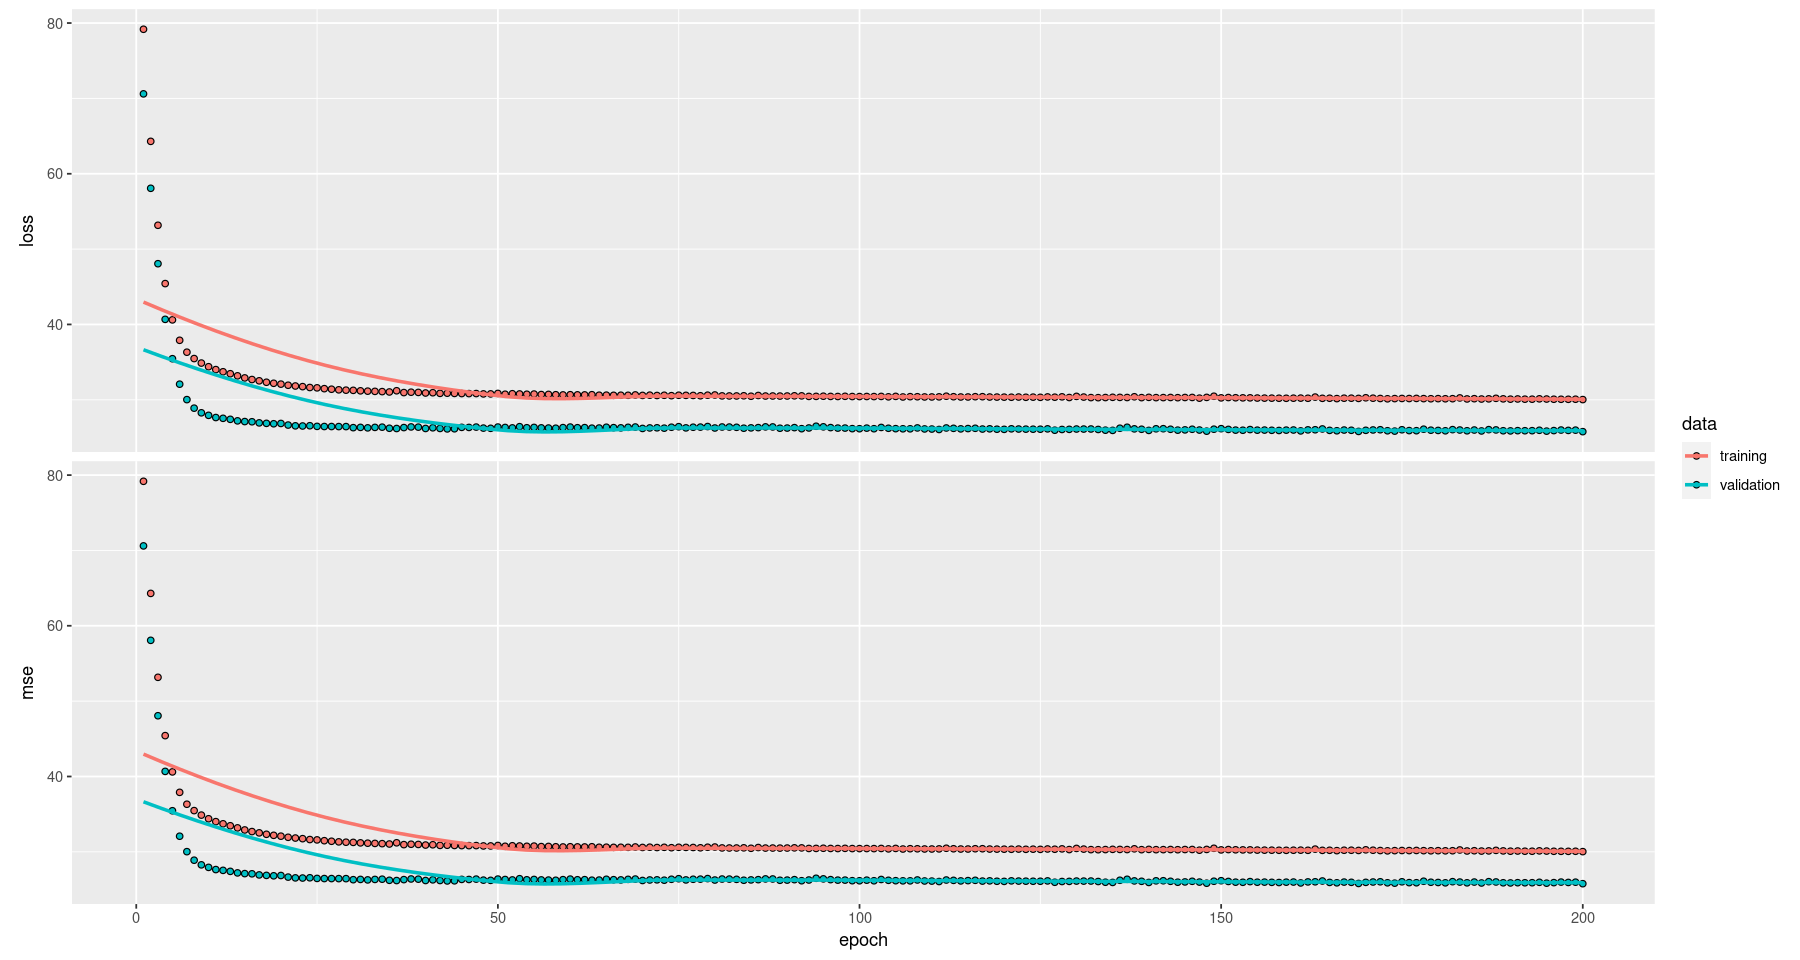

In [167]:
plot(trained_model2)

In [171]:
evaluate(model2,X_train,y_train)

loss      mse 
29.58875 29.58875

In [172]:
y2 = predict(model2,X_train)

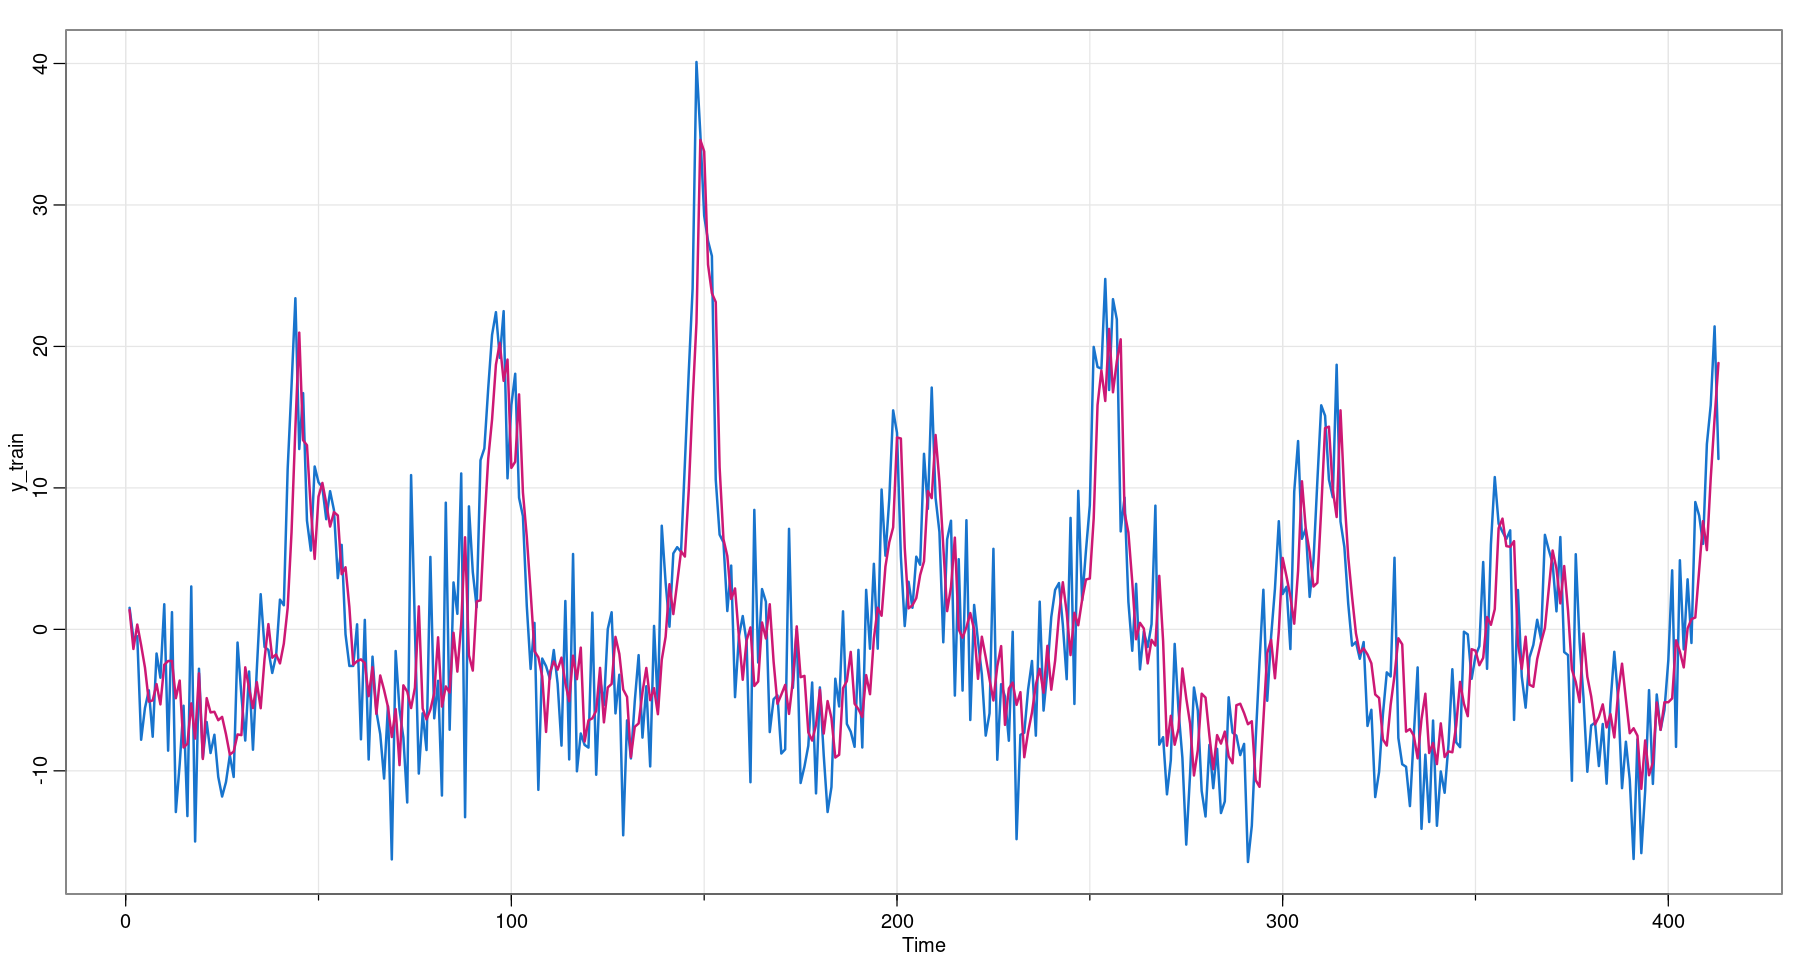

In [173]:
tsplot(y_train, col=4, lwd=2)
lines(y2, col=6, lwd=2)

## Modelo 3: agregando características

Agreguemos ahora al conjunto de entrenamiento algunas funciones del tiempo. Por ejemplo, el momento del año usando $\sin$ y $\cos$ como antes

### Preprocesamiento

In [174]:
window=3
pred = 1
x_train = x[time(x)<1978]
sint = sin(2*pi*time(x))
cost = cos(2*pi*time(x))

n=length(x_train)

X_train = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_train = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_train[i,,1] = x_train[i:(i+window-1)]
    X_train[i,,2] = sint[i:(i+window-1)]
    X_train[i,,3] = cost[i:(i+window-1)]
    y_train[i,] = x_train[(i+window):(i+window+pred-1)]
}
dim(X_train)
dim(y_train)

[1] 413   3   3

[1] 413   1

### Ajuste

In [175]:
# initialize our model
model3 <- keras_model_sequential()

model3 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 1)

In [176]:
summary(model3)

Model: "sequential_17"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_13 (Flatten)                (None, 9)                       0           
________________________________________________________________________________
dense_28 (Dense)                    (None, 1)                       10          
Total params: 10
Trainable params: 10
Non-trainable params: 0
________________________________________________________________________________


In [177]:
model3 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [178]:
trained_model3 <- model3 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



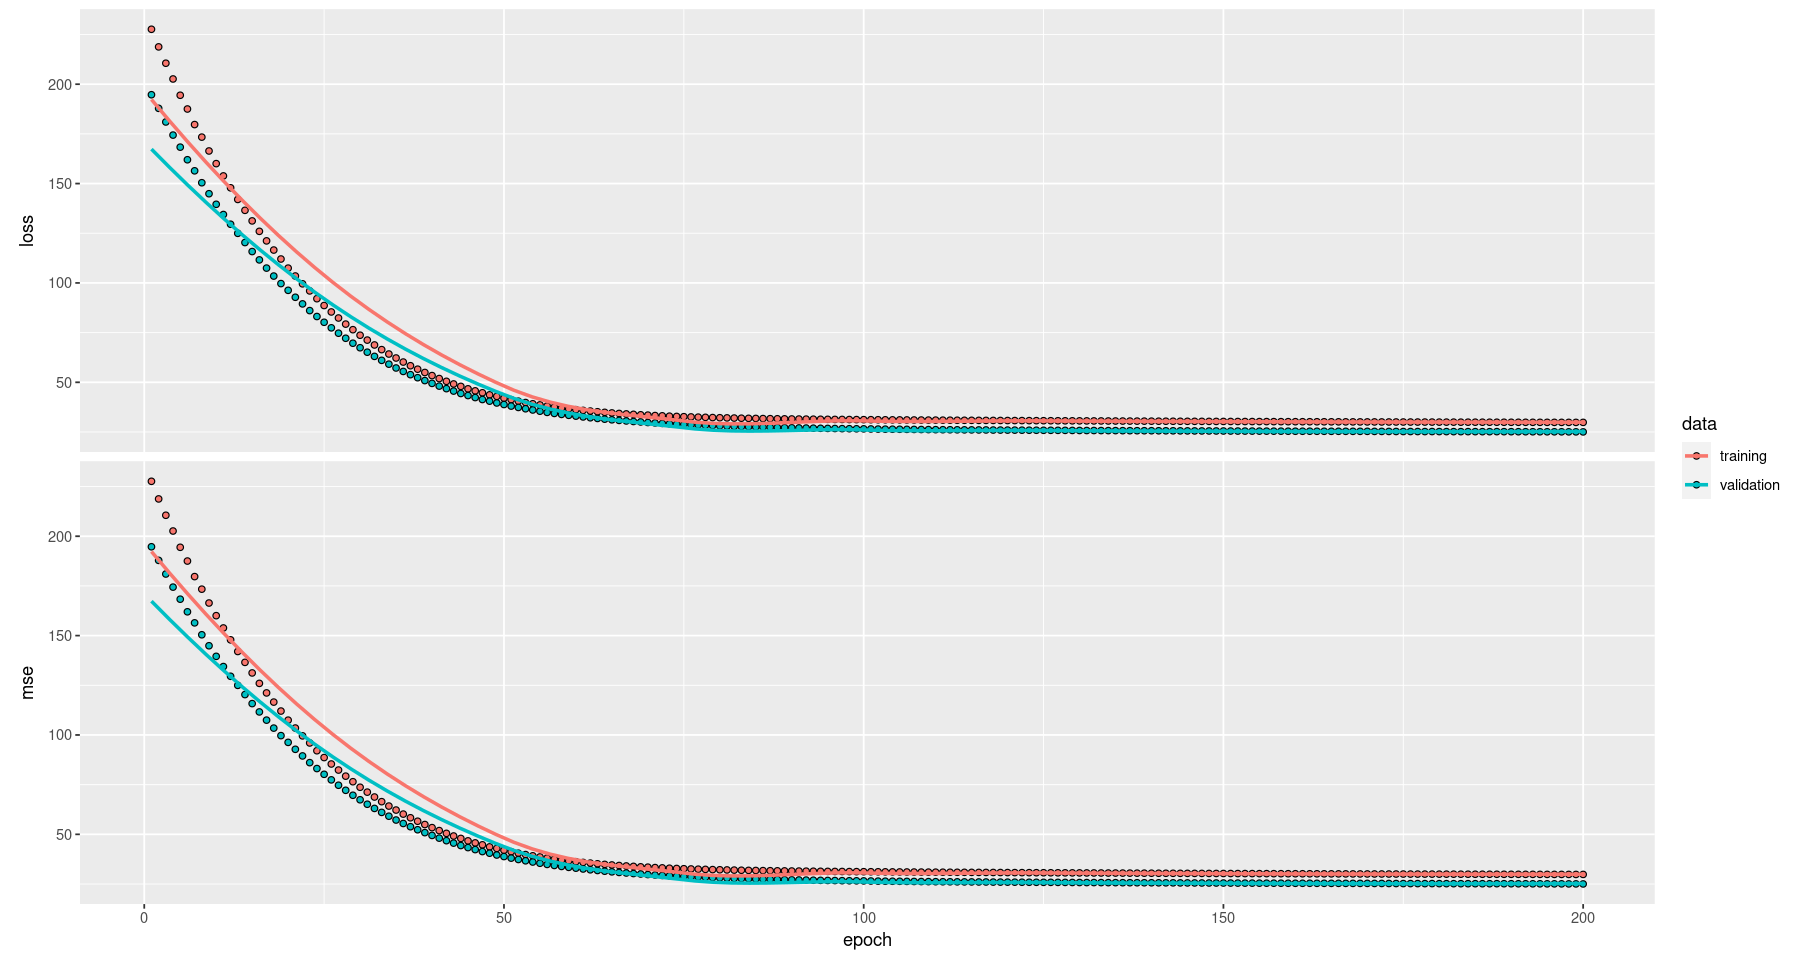

In [179]:
plot(trained_model3)

In [180]:
model3$weights

[[1]]
<tf.Variable 'dense_28/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.05909968],
       [-0.4072507 ],
       [ 1.0763197 ],
       [ 0.4681609 ],
       [-1.1159682 ],
       [ 0.17028417],
       [ 0.30488247],
       [-0.9513114 ],
       [ 0.06860401]], dtype=float32)>

[[2]]
<tf.Variable 'dense_28/bias:0' shape=(1,) dtype=float32, numpy=array([0.0015693], dtype=float32)>


In [182]:
evaluate(model3, X_train, y_train)

loss      mse 
29.32603 29.32603

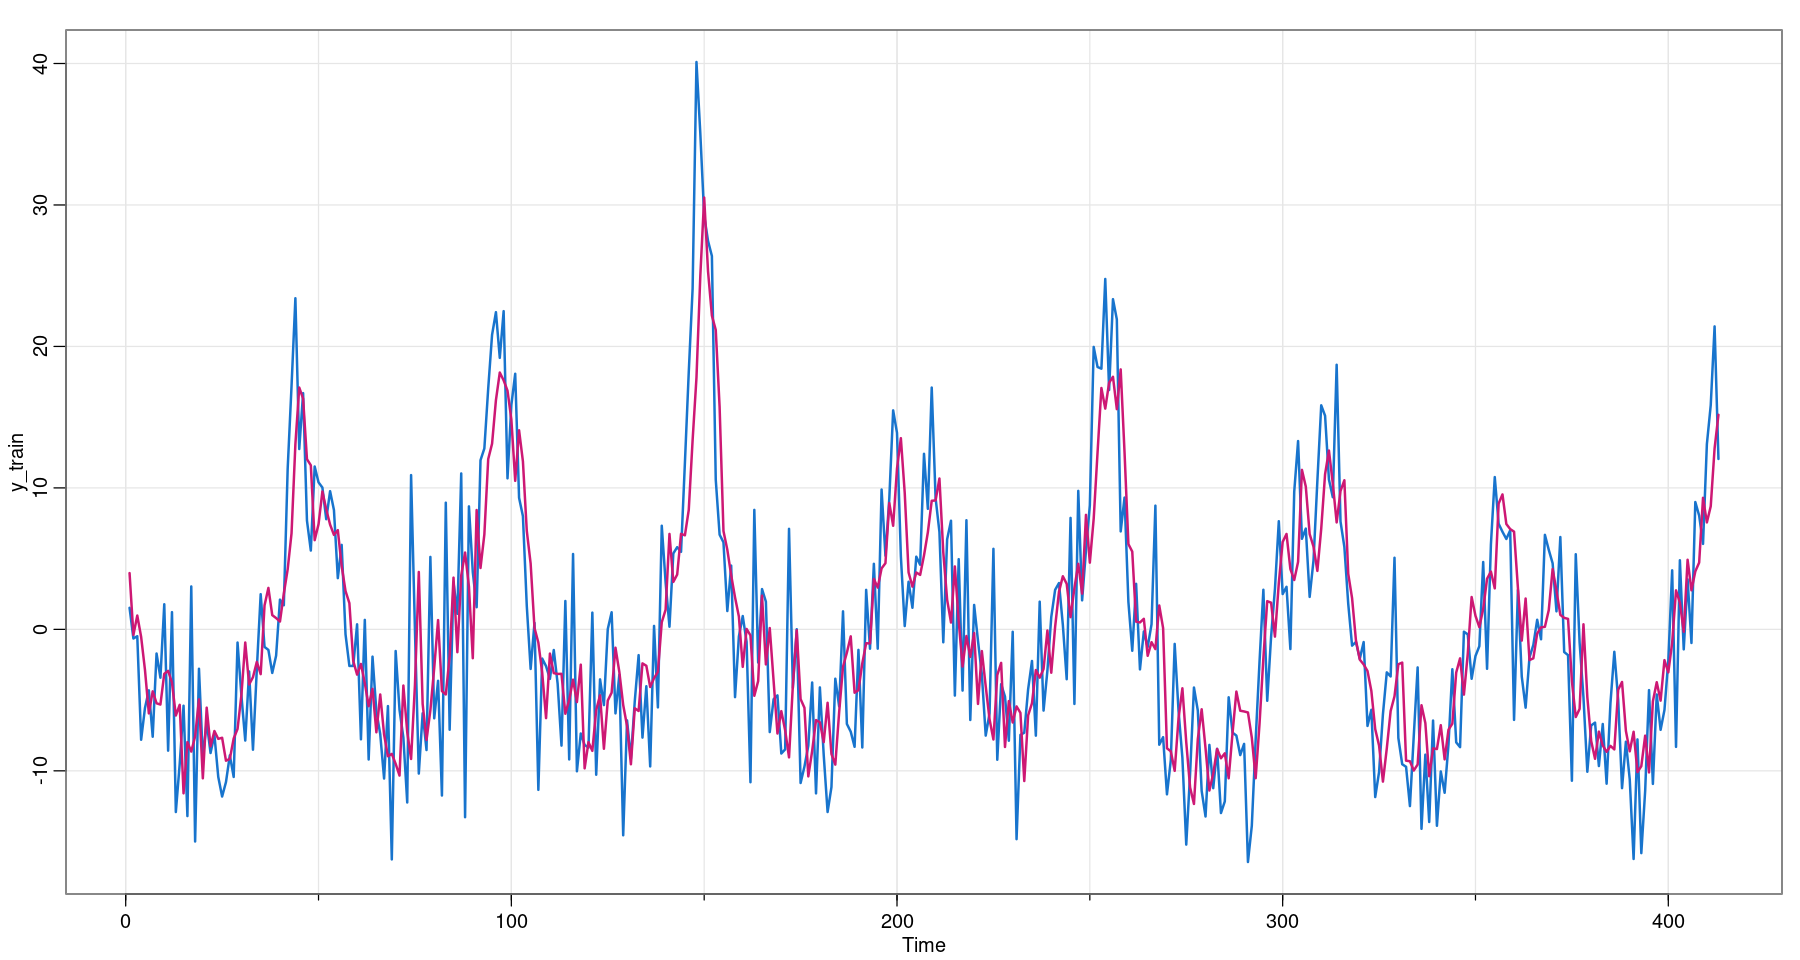

In [183]:
y3 = predict(model3,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y3, col=6, lwd=2)

## Modelo 4: características y capas

Agreguemos un par de capas densas intermedias

In [184]:
# initialize our model
model4 <- keras_model_sequential()

model4 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 32, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

In [185]:
summary(model4)

Model: "sequential_18"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_14 (Flatten)                (None, 9)                       0           
________________________________________________________________________________
dense_31 (Dense)                    (None, 32)                      320         
________________________________________________________________________________
dense_30 (Dense)                    (None, 16)                      528         
________________________________________________________________________________
dense_29 (Dense)                    (None, 1)                       17          
Total params: 865
Trainable params: 865
Non-trainable params: 0
________________________________________________________________________________


In [186]:
model4 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [187]:
trained_model4 <- model4 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



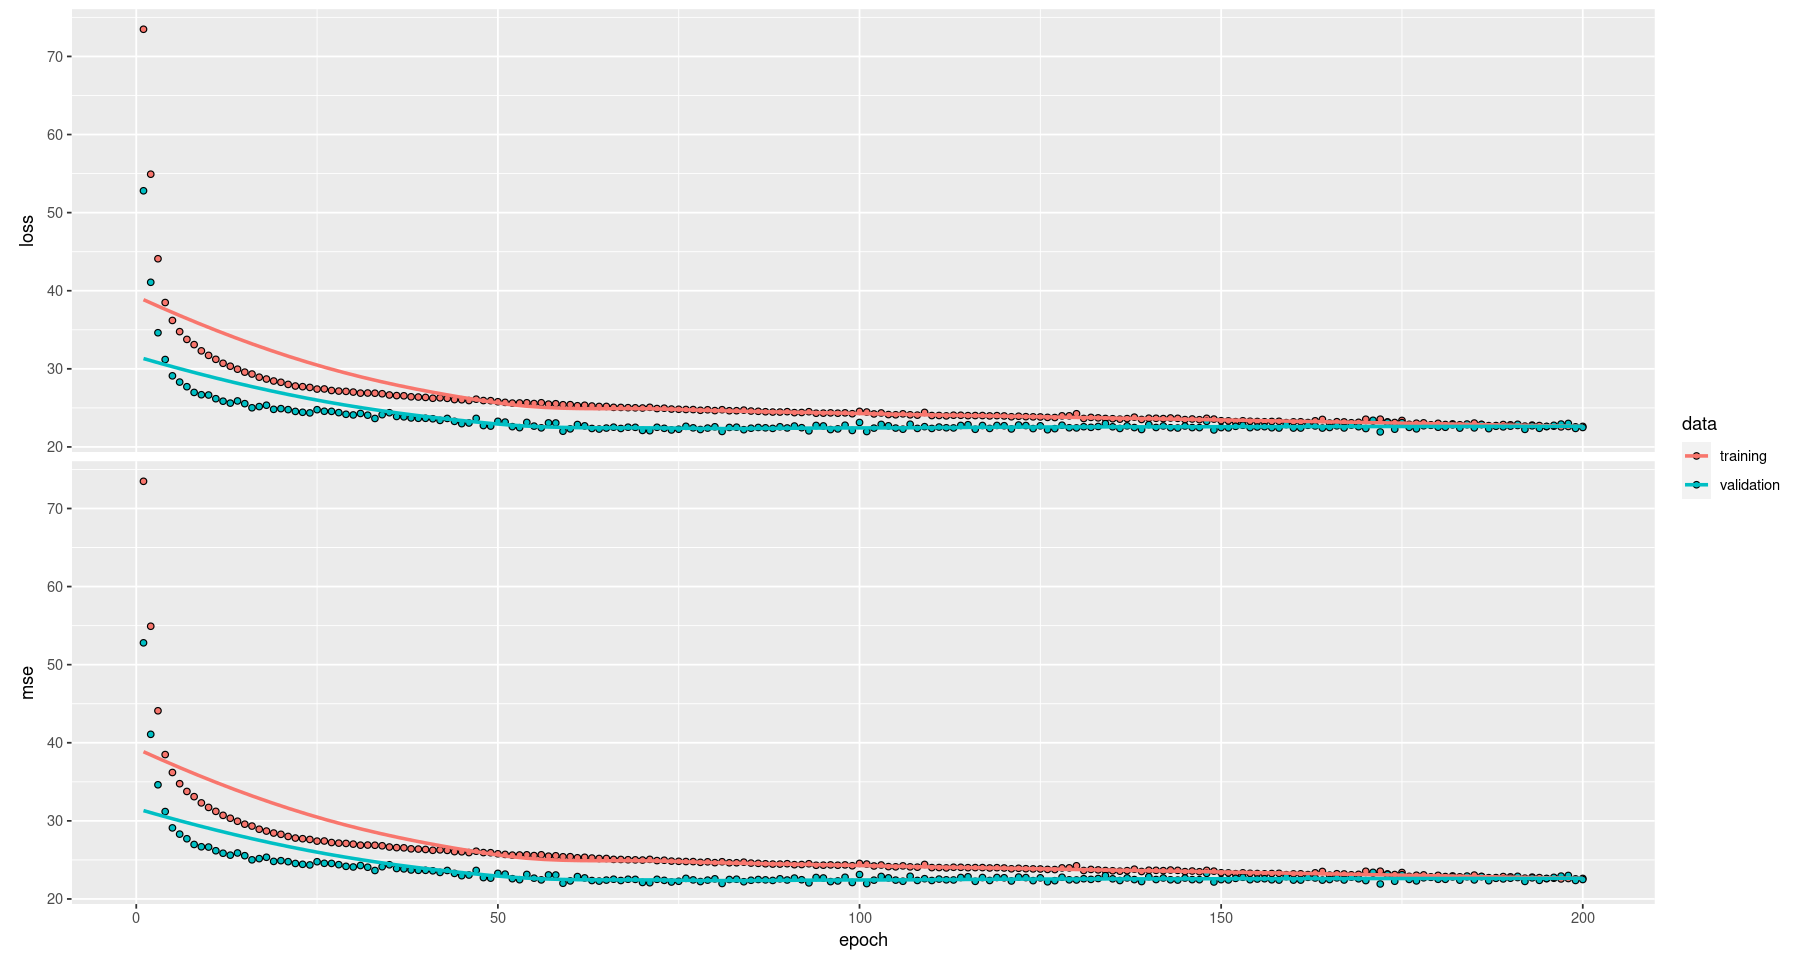

In [188]:
plot(trained_model4)

In [189]:
evaluate(model4, X_train, y_train)

loss     mse 
22.3978 22.3978

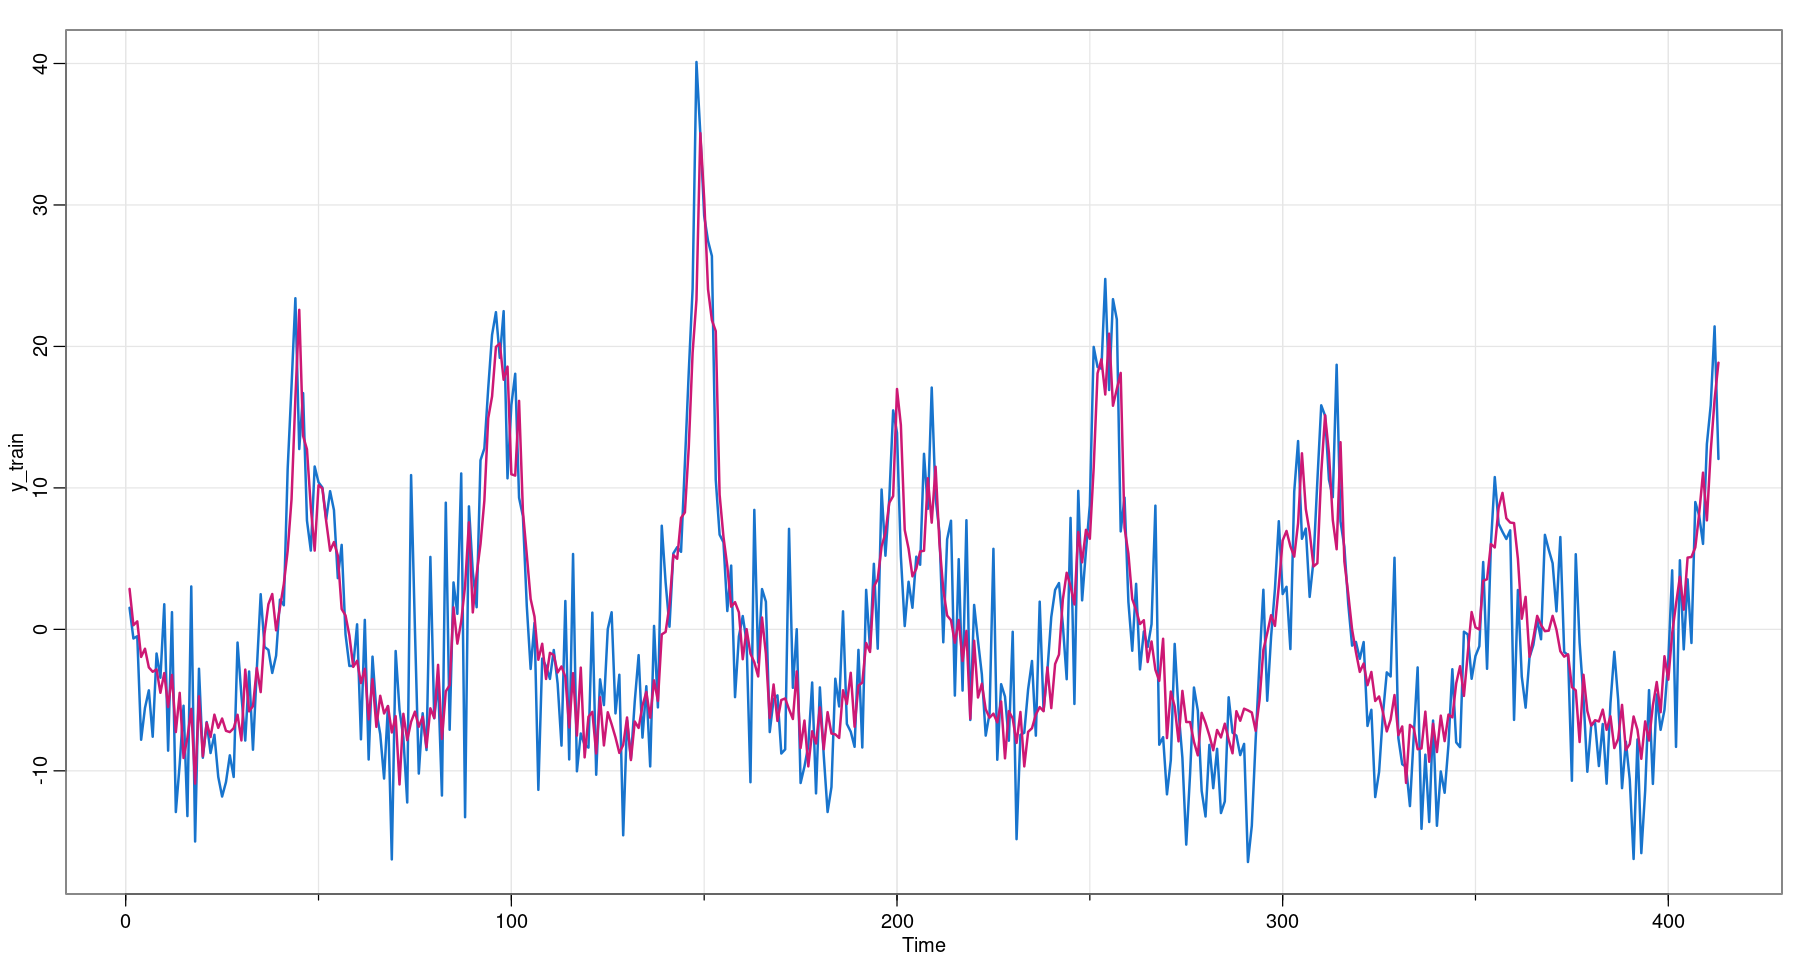

In [190]:
y4 = predict(model4,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y4, col=6, lwd=2)

## Modelo 5: Convolutional Neural Network

La idea de la capa convolucional o CNN es similar a la de los procesos autorregresivos y a lo que veníamos haciendo antes, solo que simplifica un poco la escritura del modelo. El de abajo es esencialmente el mismo modelo 4 pero usando CNNs.

![CNN](cnn.png)

In [191]:
# initialize our model
model5 <- keras_model_sequential()

model5 %>%
    layer_conv_1d(input_shape = dim(X_train)[2:3], filters = 32, kernel_size=window, activation="relu") %>%
    layer_dense(units = 16, activation="relu") %>%
    layer_dense(units = 1)

In [192]:
summary(model5)

Model: "sequential_19"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv1d_1 (Conv1D)                   (None, 1, 32)                   320         
________________________________________________________________________________
dense_33 (Dense)                    (None, 1, 16)                   528         
________________________________________________________________________________
dense_32 (Dense)                    (None, 1, 1)                    17          
Total params: 865
Trainable params: 865
Non-trainable params: 0
________________________________________________________________________________


In [193]:
model5 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [194]:
trained_model5 <- model5 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



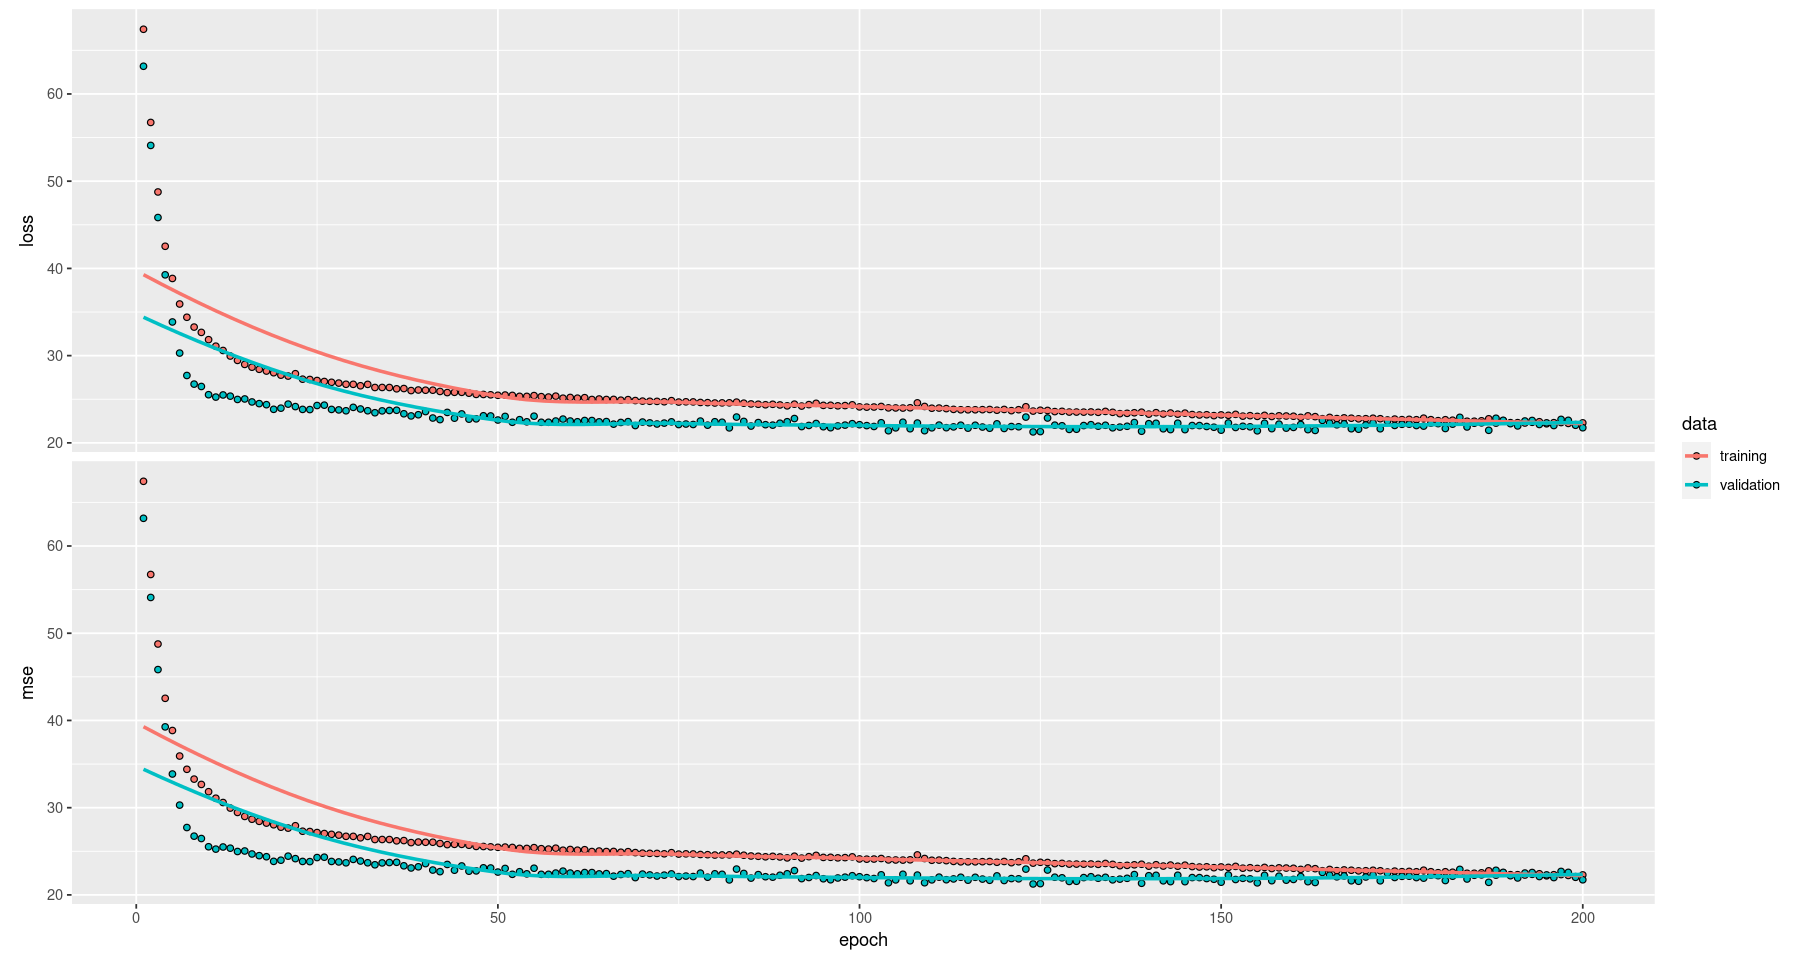

In [195]:
plot(trained_model5)

In [196]:
evaluate(model5, X_train, y_train)

loss      mse 
21.99065 21.99065

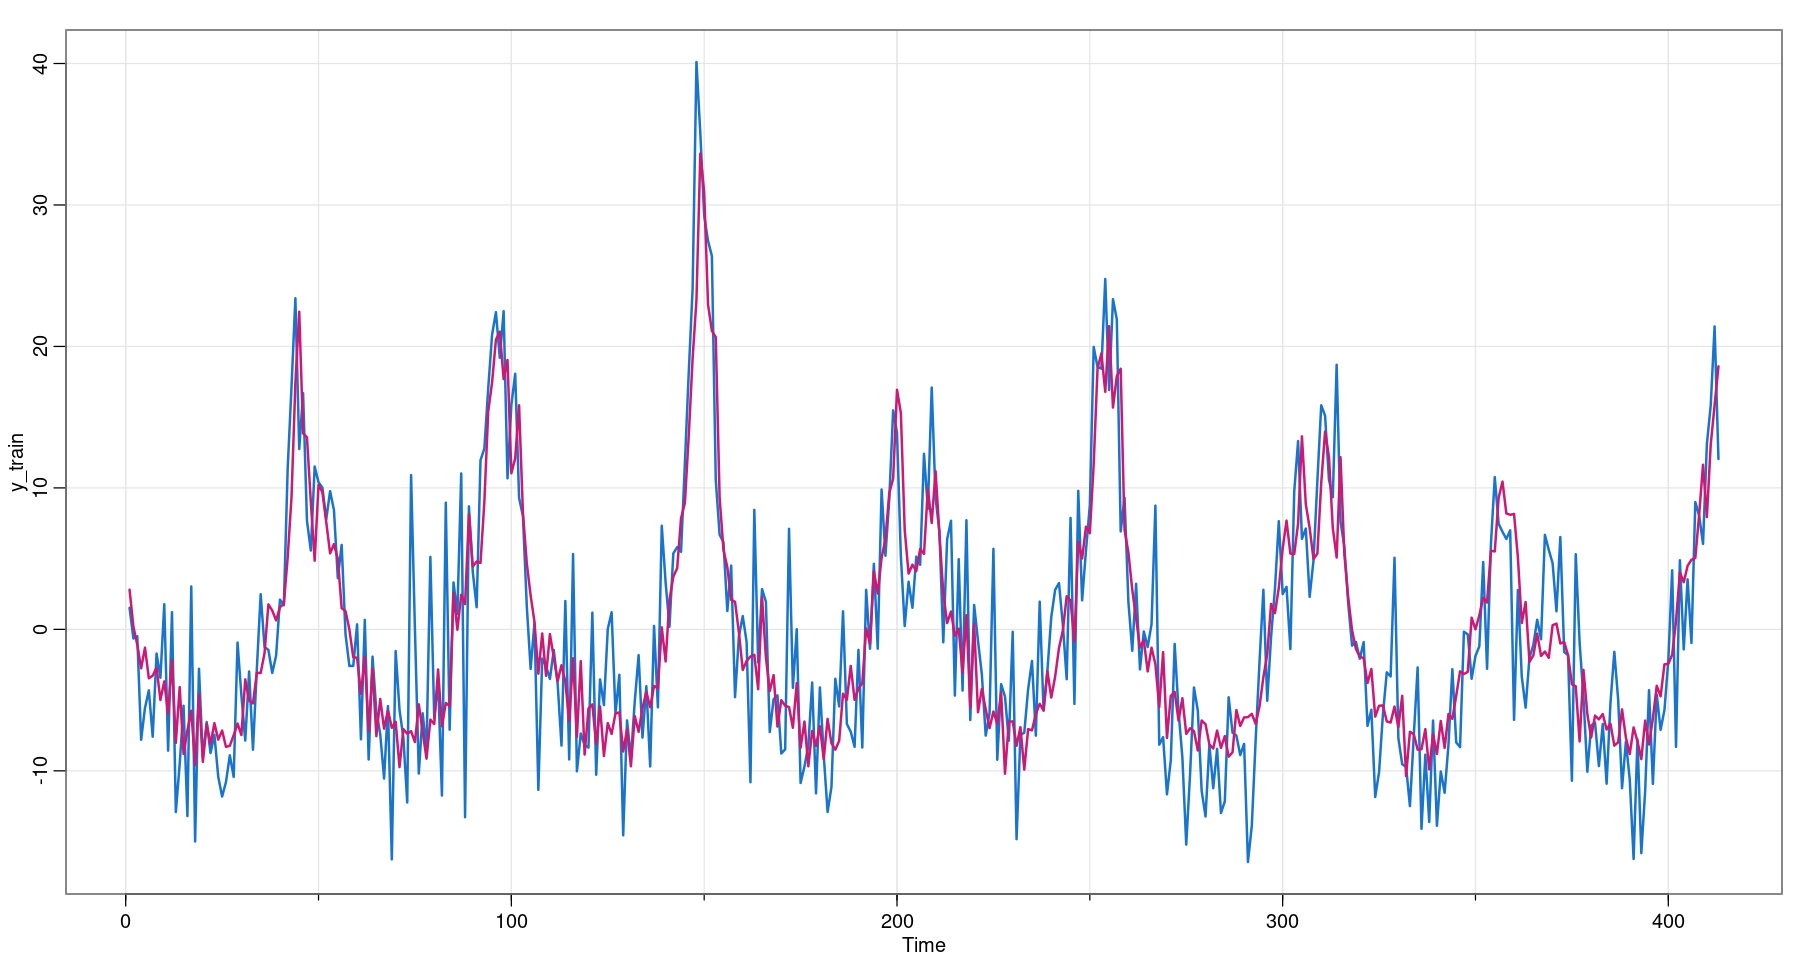

In [198]:
y5 = predict(model5,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y5, col=6, lwd=2)

## Recurrent Neural Networks

Estas redes permiten "guardar estado" y en algún sentido son la generalización no lineal del Dynamic Linear model que ya vimos. Permiten en algún sentido agregar memoria.

El proceso en una capa RNN es:

![RNN](rnn.png)

## Modelo 6: Simple RNN

La red recurrente simple tiene "memoria corta" y presenta problemas de ajuste ("vanishing and exploding gradiemts") cuando uno hace el algoritmo de Backpropagation adaptado a las mismas.

In [223]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [224]:
summary(model6)

Model: "sequential_25"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
simple_rnn_6 (SimpleRNN)            (None, 8)                       96          
________________________________________________________________________________
dense_39 (Dense)                    (None, 1)                       9           
Total params: 105
Trainable params: 105
Non-trainable params: 0
________________________________________________________________________________


In [225]:
model6 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [226]:
trained_model6 <- model6 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



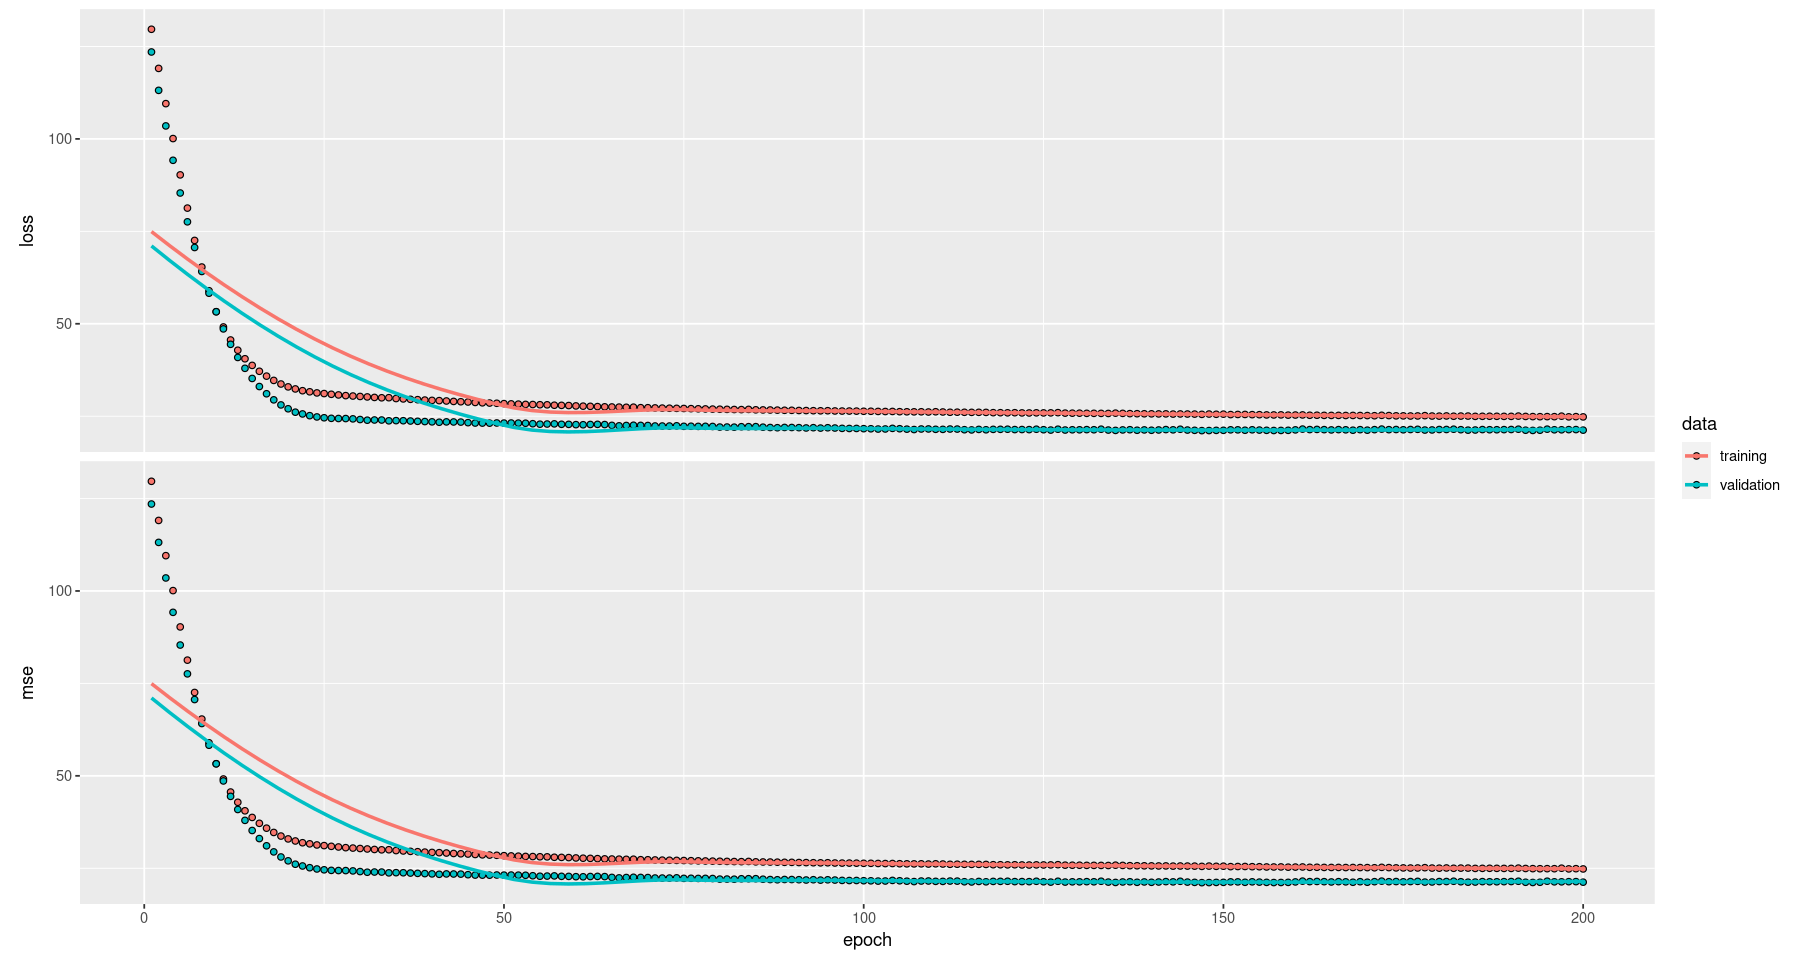

In [227]:
plot(trained_model6)

In [228]:
evaluate(model6, X_train, y_train)

loss      mse 
24.40895 24.40895

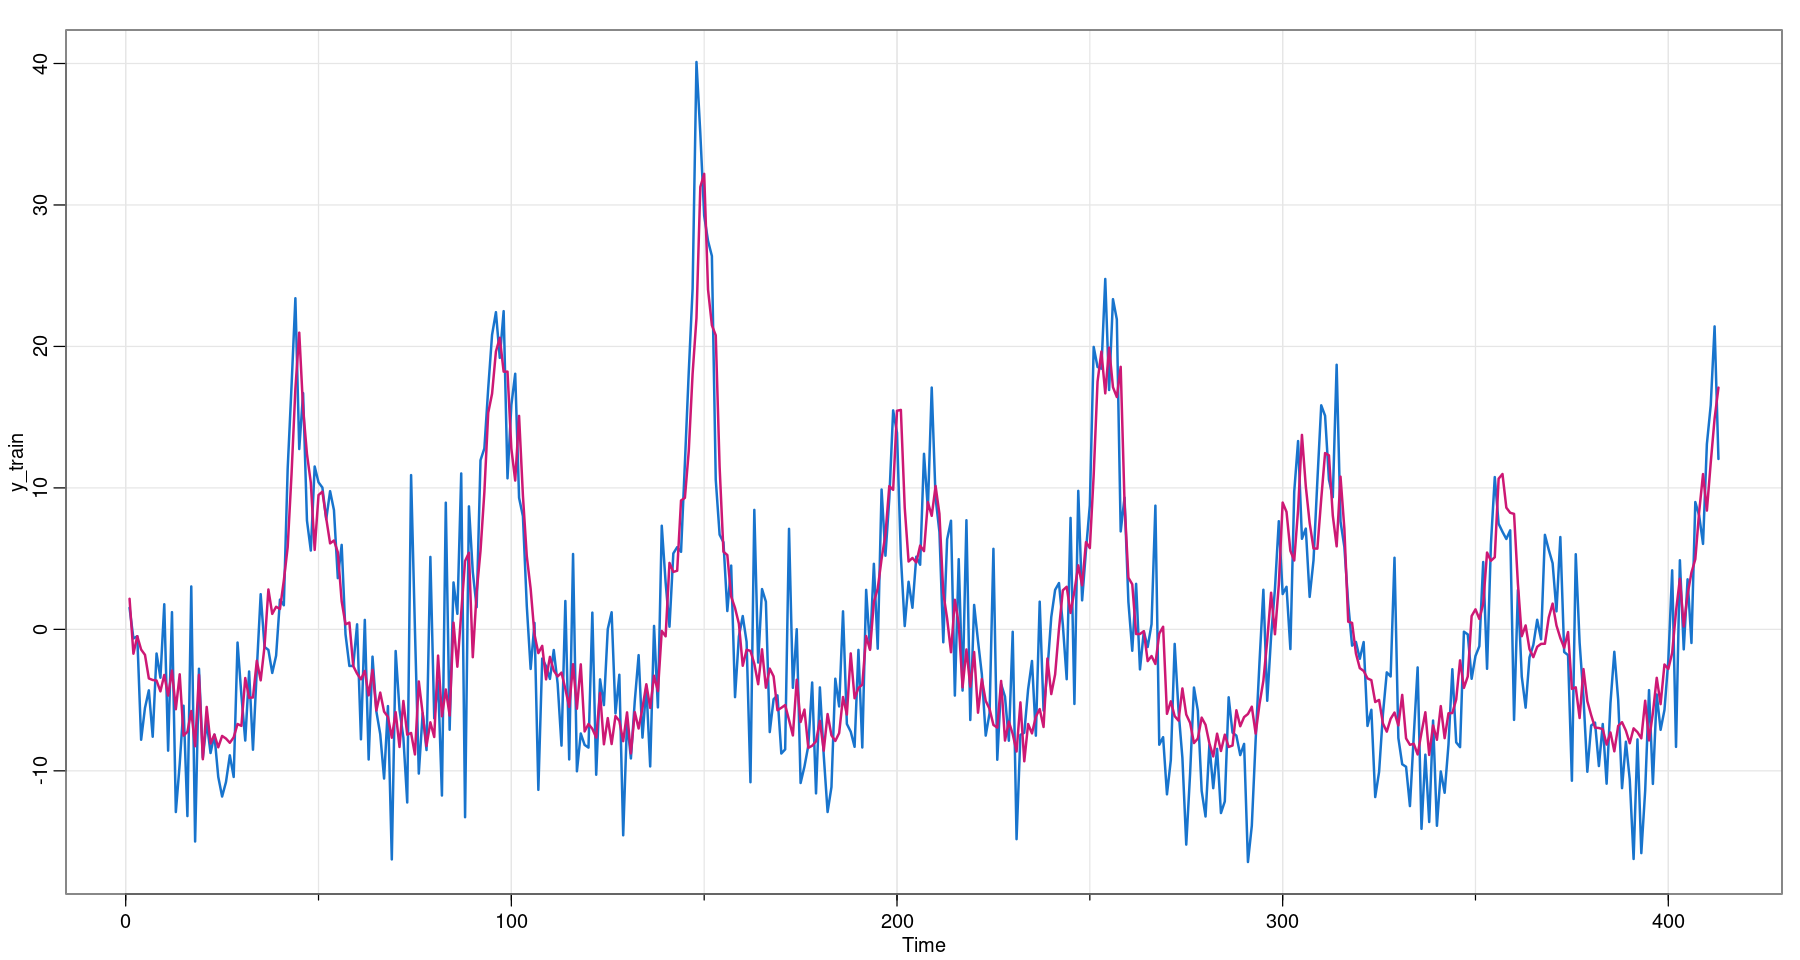

In [229]:
y6 = predict(model6,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y6, col=6, lwd=2)

## Modelo 7: LSTM

La red recurrente LSTM funciona igual que la red RNN en principio, pero tiene más "gates" y parámetros internos para permitir guardar más estado interno. Estas redes son muy usadas para series temporales.

In [230]:
# initialize our model
model7 <- keras_model_sequential()

model7 %>%
    layer_lstm(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [231]:
summary(model7)

Model: "sequential_26"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm_2 (LSTM)                       (None, 8)                       384         
________________________________________________________________________________
dense_40 (Dense)                    (None, 1)                       9           
Total params: 393
Trainable params: 393
Non-trainable params: 0
________________________________________________________________________________


In [232]:
model7 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [233]:
trained_model7 <- model7 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



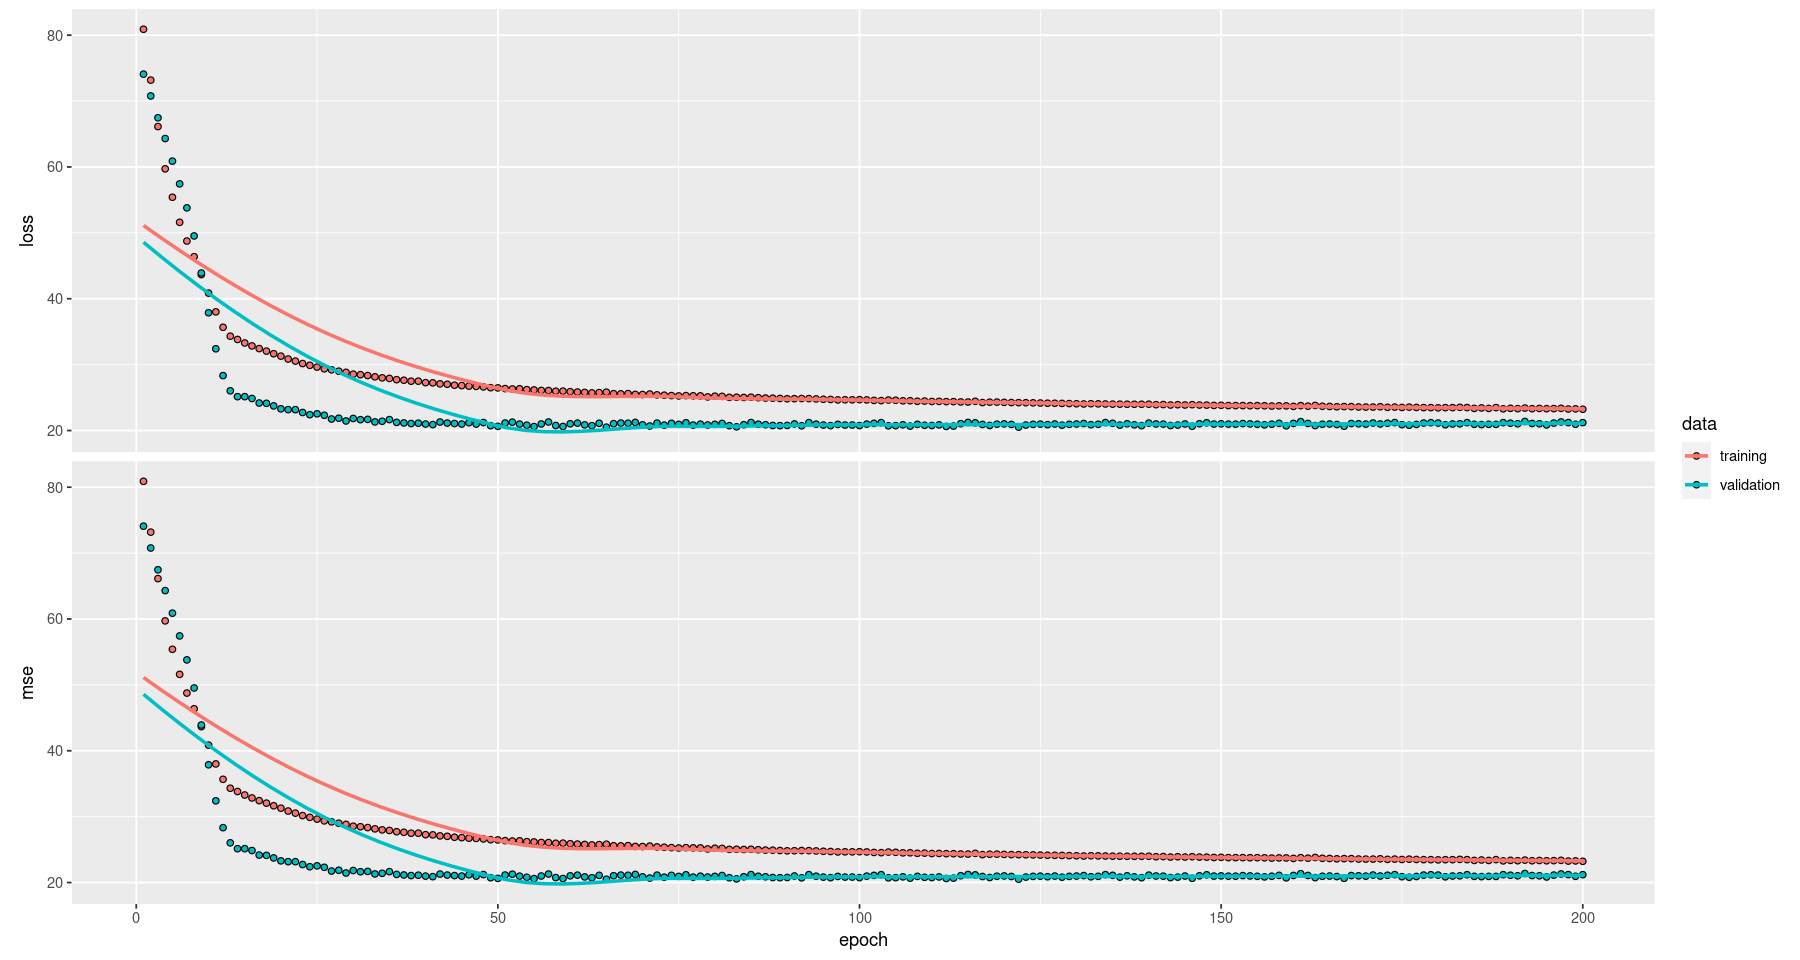

In [234]:
plot(trained_model7)

In [235]:
evaluate(model7, X_train, y_train)

loss      mse 
22.94162 22.94162

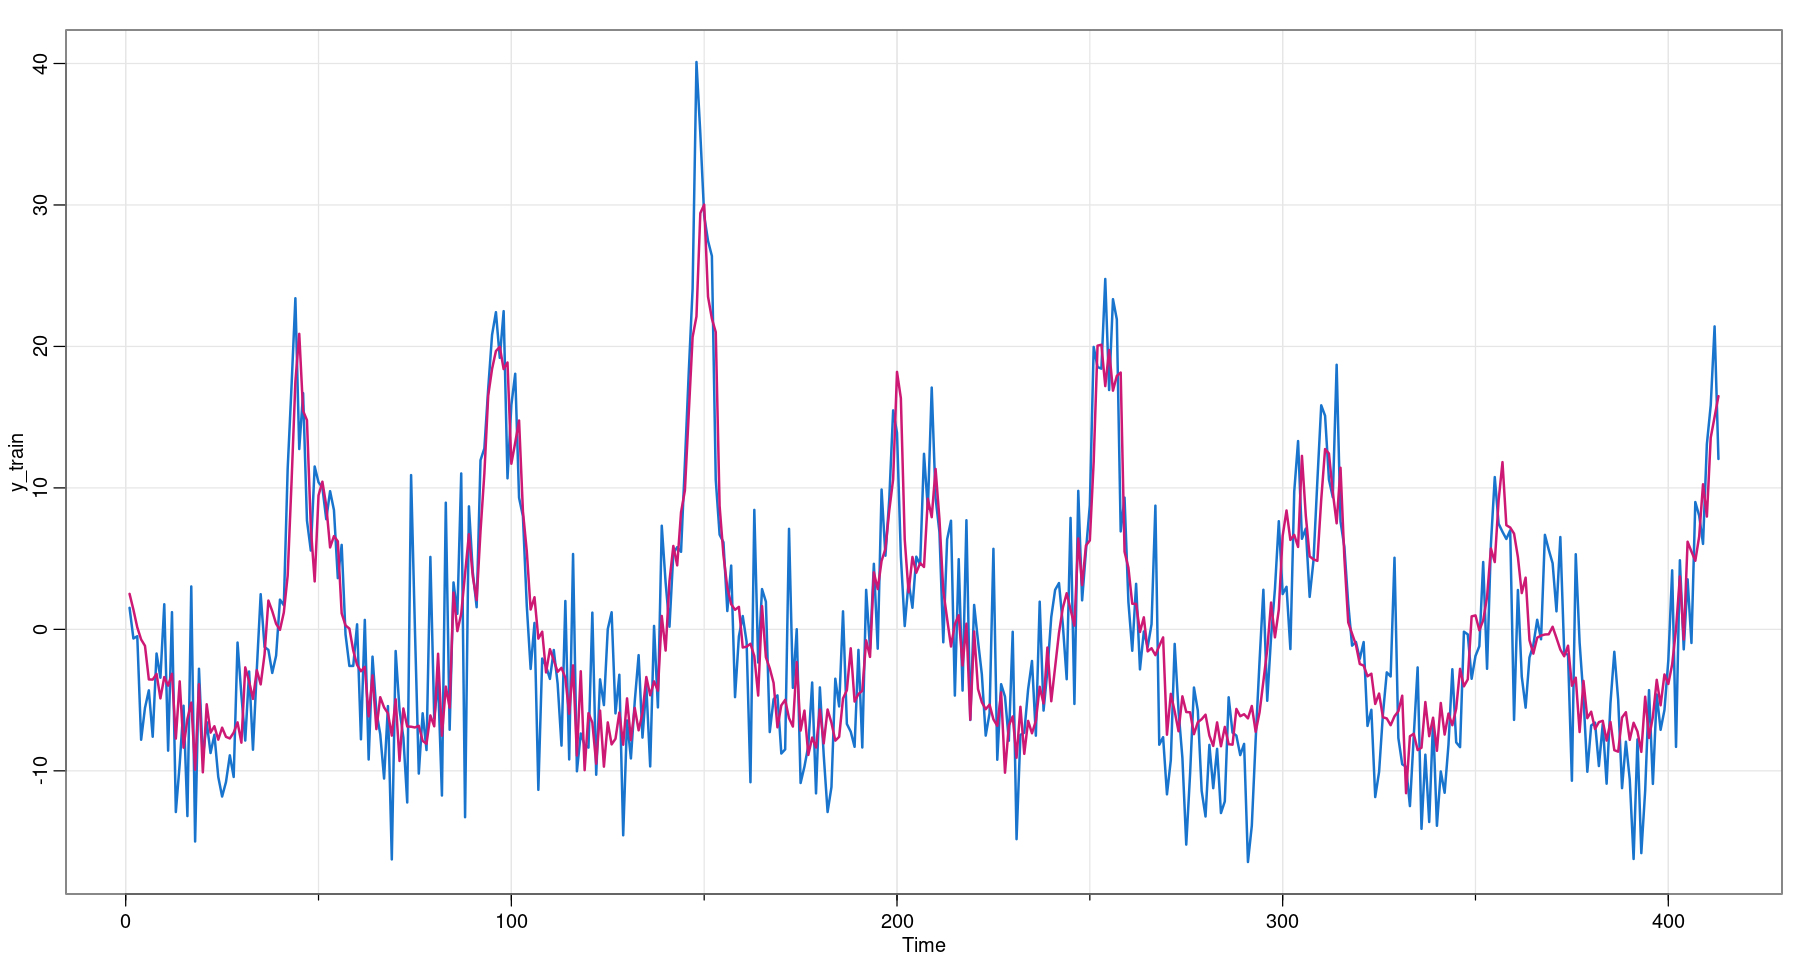

In [236]:
y7 = predict(model7,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y7, col=6, lwd=2)

## Modelo 8: LSTM +  capas

Agreguemos alguna capa densa más.

In [248]:
# initialize our model
model8 <- keras_model_sequential()

model8 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 8, activation = "relu") %>%
    layer_lstm(units = 8, activation="relu") %>%
    layer_dense(units = 8, activation="relu") %>%
    layer_dense(units = 1)

In [249]:
summary(model8)

Model: "sequential_28"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_46 (Dense)                    (None, 3, 8)                    32          
________________________________________________________________________________
lstm_4 (LSTM)                       (None, 8)                       544         
________________________________________________________________________________
dense_45 (Dense)                    (None, 8)                       72          
________________________________________________________________________________
dense_44 (Dense)                    (None, 1)                       9           
Total params: 657
Trainable params: 657
Non-trainable params: 0
________________________________________________________________________________


In [250]:
model8 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [251]:
trained_model8 <- model8 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 200, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



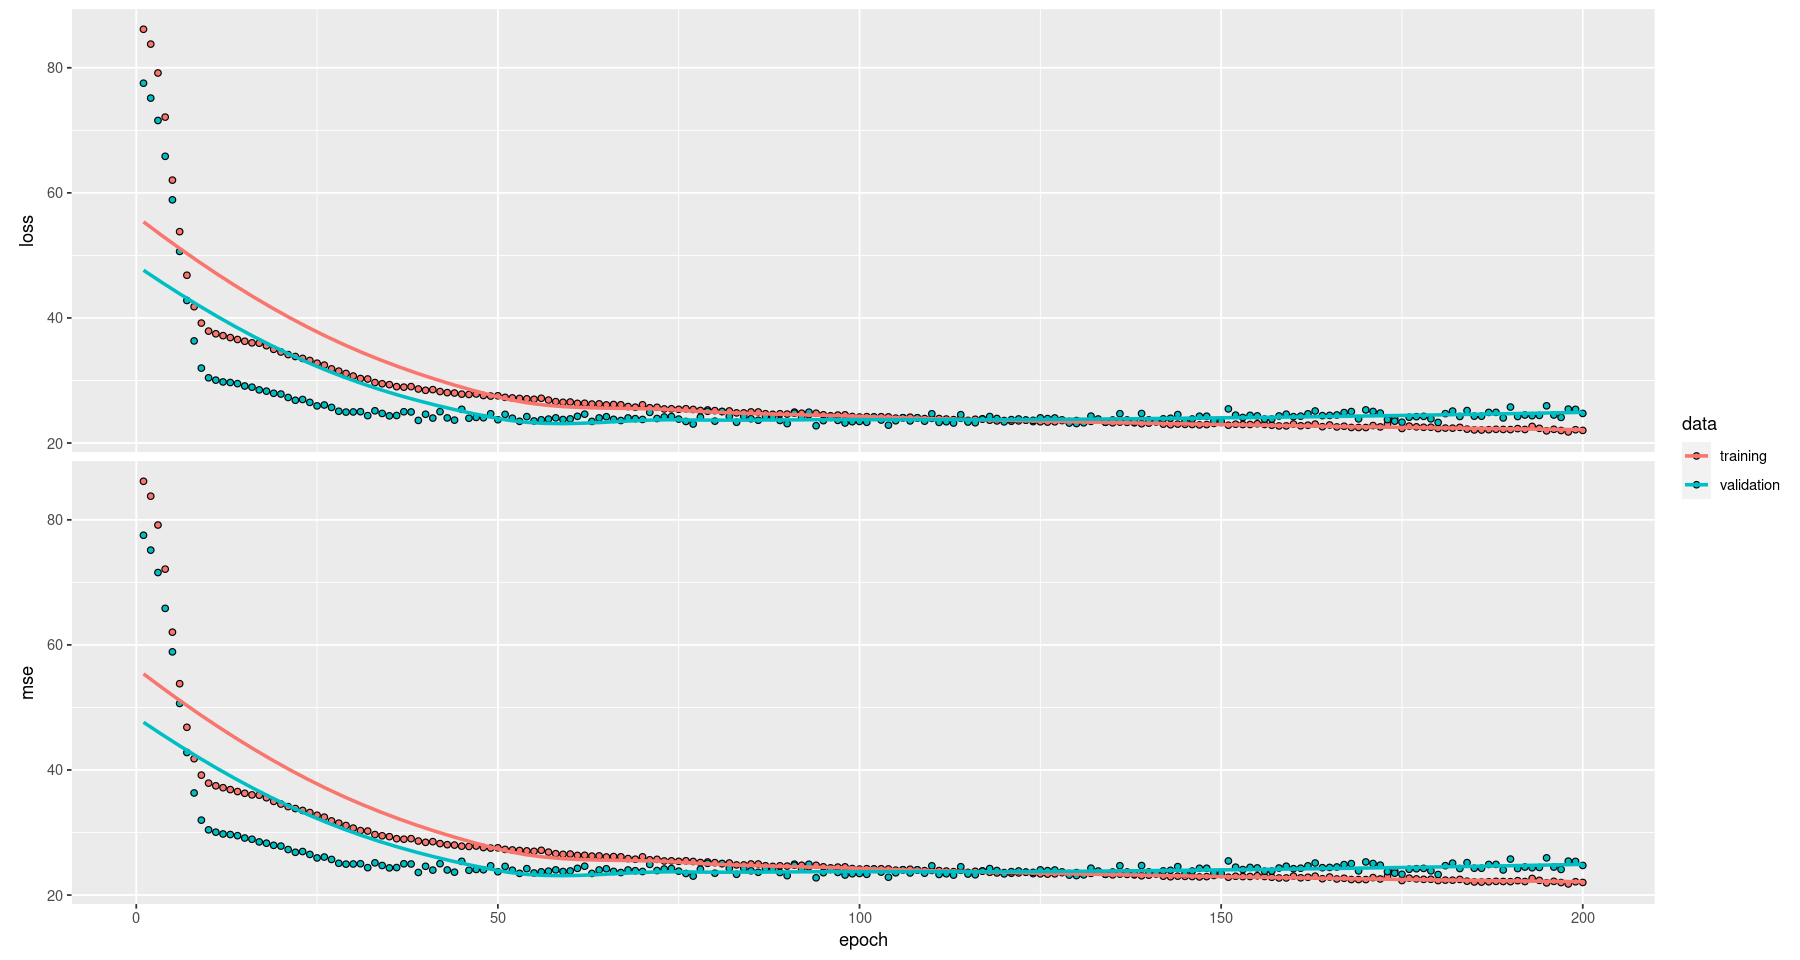

In [252]:
plot(trained_model8)

In [253]:
evaluate(model8, X_train, y_train)

loss      mse 
21.98642 21.98642

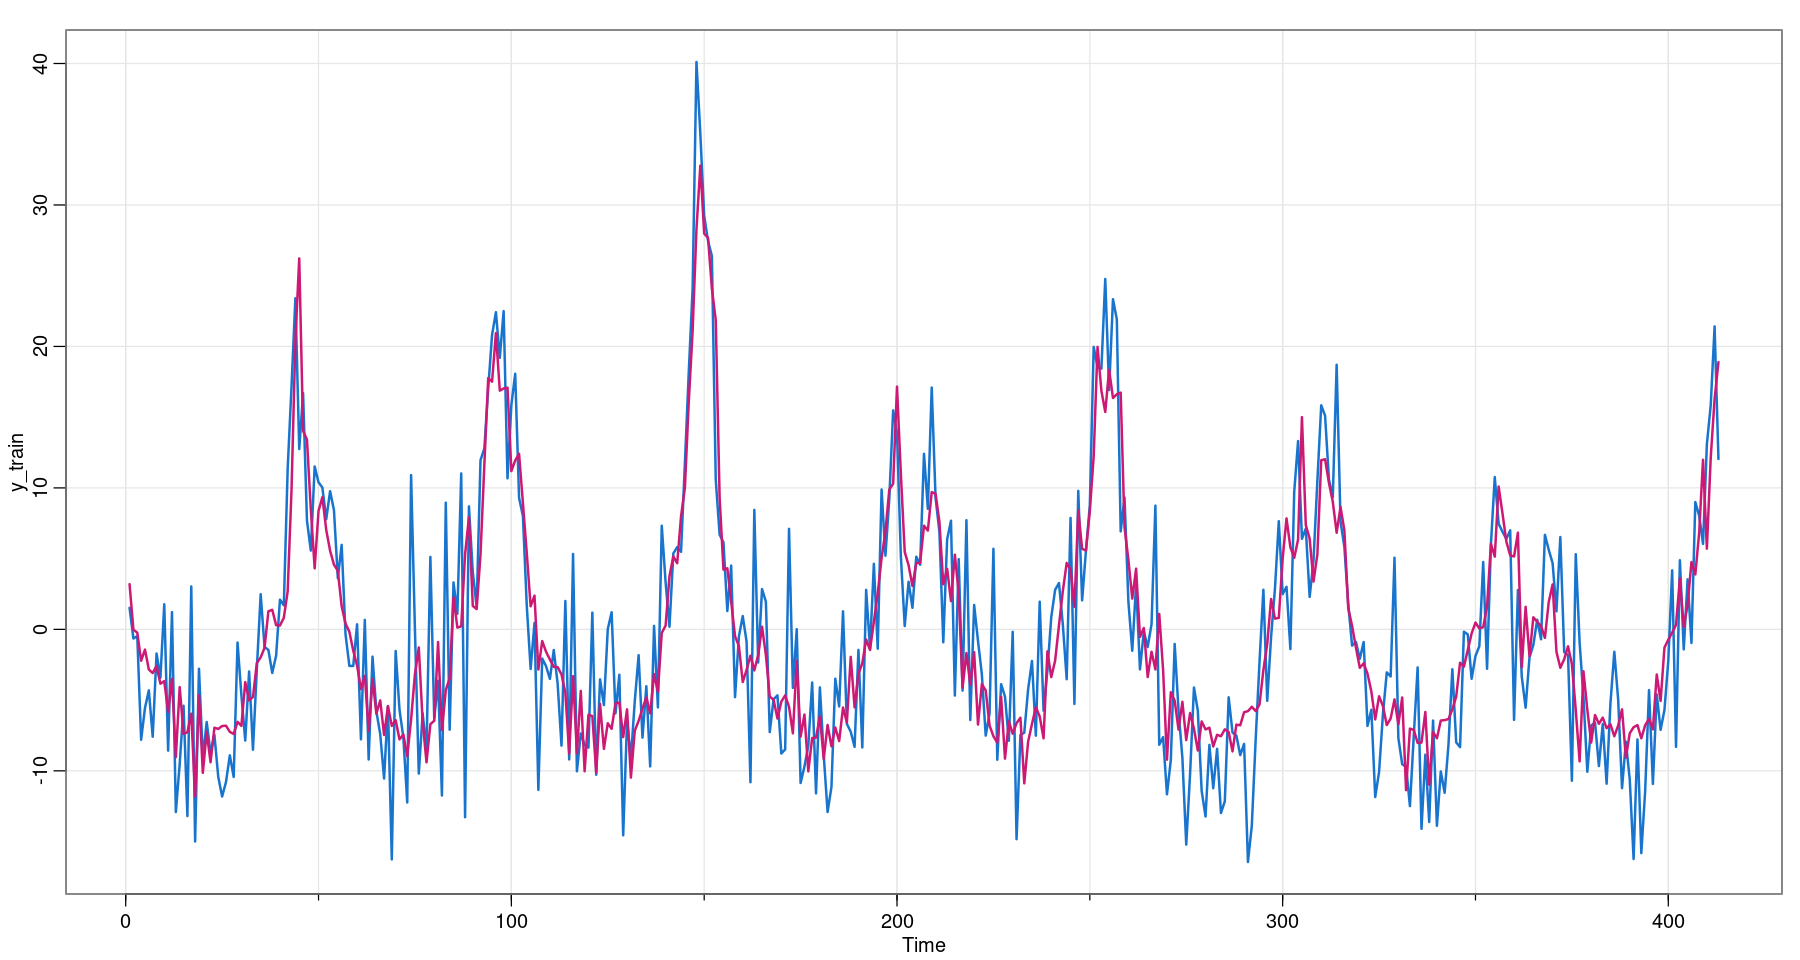

In [254]:
y8 = predict(model8,X_train)

tsplot(y_train, col=4, lwd=2)
lines(y8, col=6, lwd=2)

## Evaluación.

Evaluemos algunos de estos modelos haciendo la predicción sobre los años que faltan.

In [257]:
x_test = x[time(x)>=1978]
x_test = ts(x_test, start=1978, freq=52)

sint = sin(2*pi*time(x_test))
cost = cos(2*pi*time(x_test))

In [261]:
n=length(x_test)

X_test = array(,dim=c(n-window-pred+1,window,3)) #el ultimo son los features
y_test = matrix(,n-window-pred+1,pred)

for (i in 1:(n-window-pred+1)) {
    X_test[i,,1] = x[i:(i+window-1)]
    X_test[i,,2] = sint[i:(i+window-1)]
    X_test[i,,3] = cost[i:(i+window-1)]
    y_test[i,] = x[(i+window):(i+window+pred-1)]
}
dim(X_test)
dim(y_test)

[1] 89  3  3

[1] 89  1

In [269]:
evaluate(model8,X_test,y_test)

loss      mse 
26.82441 26.82441

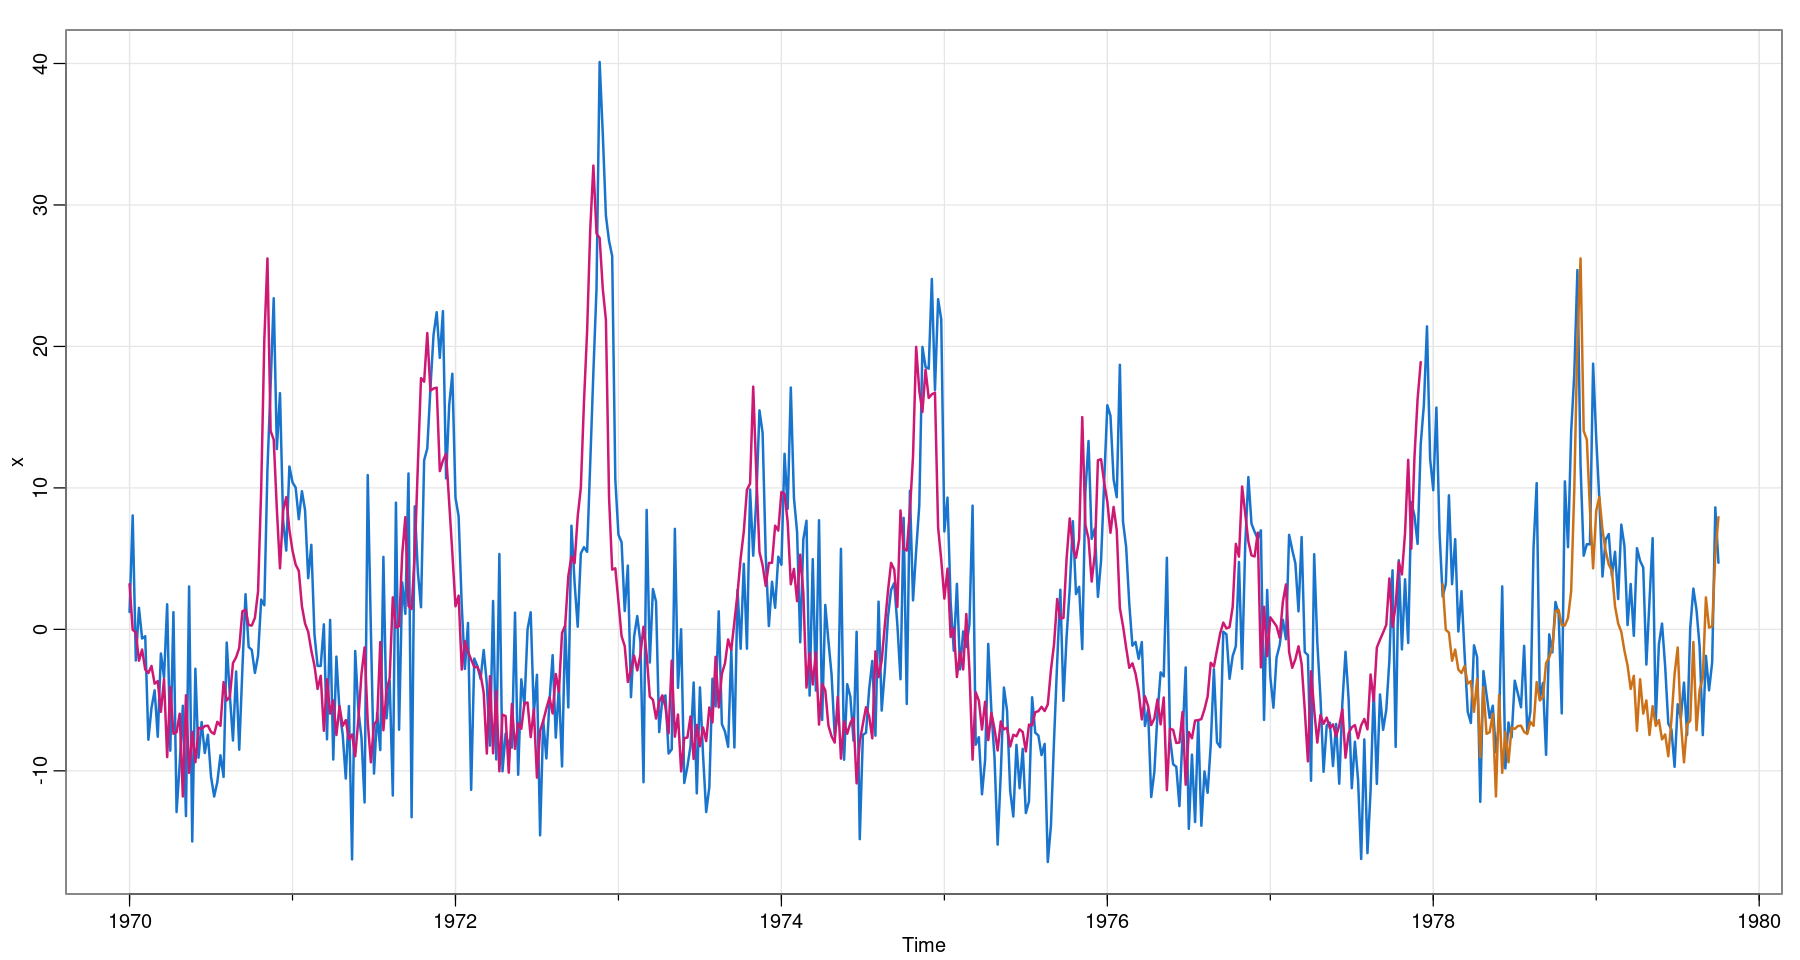

In [273]:
y8_test = predict(model8,X_test)
y8_test = ts(y8_test, start=1978+3/52, freq=52)
#y8 = ts(y8, start=1970, freq=52)

tsplot(x, col=4, lwd=2)
lines(y8, col=6, lwd=2)
lines(y8_test, col=7, lwd=2)